In [1]:
# Uncomment to use autoreload
%load_ext autoreload
%autoreload 2

import os
import os.path as osp
import sys
import torch
import numpy as np
from time import time
from omegaconf import OmegaConf
start = time()
import warnings
warnings.filterwarnings('ignore')

# torch.cuda.set_device(I_GPU)
DIR = os.path.dirname(os.getcwd())
ROOT = os.path.join(DIR, "..")
sys.path.insert(0, ROOT)
sys.path.insert(0, DIR)

from torch_points3d.utils.config import hydra_read
from torch_geometric.data import Data
from torch_points3d.core.multimodal.data import MMData, MMBatch
from torch_points3d.visualization.multimodal_data import visualize_mm_data
from torch_points3d.core.multimodal.image import SameSettingImageData, ImageData
from torch_points3d.datasets.segmentation.multimodal.scannet import ScannetDatasetMM
from torch_points3d.datasets.segmentation.scannet import CLASS_COLORS, CLASS_NAMES, CLASS_LABELS
from torch_points3d.metrics.segmentation_tracker import SegmentationTracker
from torch_points3d.datasets.segmentation import IGNORE_LABEL
from torch_points3d.metrics.scannet_segmentation_tracker import ScannetSegmentationTracker
from torch_points3d.metrics.colored_tqdm import Coloredtqdm as Ctq


CLASS_COLORS[0] = (174.0, 199.0, 232.0)
CLASS_COLORS[-1] = (0, 0, 0)
import plotly.io as pio
import seaborn as sns

#pio.renderers.default = 'jupyterlab'        # for local notebook
pio.renderers.default = 'iframe_connected'  # for remote notebook. Other working (but seemingly slower) options are: 'sphinx_gallery' and 'iframe'

import matplotlib.pyplot as plt 
%matplotlib inline

colormap = mpl.cm.tab10.colors   # Qualitative colormap

MMData debug() function changed, please uncomment the 3rd assert line when doing inference without M2F features!


NameError: name 'mpl' is not defined

### Plotting functions

In [2]:
def read_scores(file):
    with open(f'/home/fsun/DeepViewAgg/job_logs/{file}') as f:
        lines = f.readlines()

        pattern = 'train_miou ='
        matching_lines = [line for line in lines if pattern in line]
        train_scores = [float(m.split()[-1]) / 100 for m in matching_lines]
        
        pattern = 'train_loss_seg ='
        matching_lines = [line for line in lines if pattern in line]
        train_losses = [float(m.split()[-1]) for m in matching_lines]
        
        pattern = 'train_loss_cross_entropy ='
        matching_lines = [line for line in lines if pattern in line]
        train_loss_cross_entropy = [float(m.split()[-1]) for m in matching_lines]
        
#         pattern = 'train_loss_2d_cross_entropy ='
#         matching_lines = [line for line in lines if pattern in line]
#         train_loss_2d_cross_entropy = [float(m.split()[-1]) for m in matching_lines]

        pattern = 'val_miou ='
        matching_lines = [line for line in lines if pattern in line]
        val_scores = [float(m.split()[-1]) / 100 for m in matching_lines]
        
        pattern = 'val_loss_seg ='
        matching_lines = [line for line in lines if pattern in line]
        val_losses = [float(m.split()[-1]) for m in matching_lines]
        
        pattern = 'val_loss_cross_entropy ='
        matching_lines = [line for line in lines if pattern in line]
        val_loss_cross_entropy = [float(m.split()[-1]) for m in matching_lines]
        
#         pattern = 'val_loss_2d_cross_entropy ='
#         matching_lines = [line for line in lines if pattern in line]
#         val_loss_2d_cross_entropy = [float(m.split()[-1]) for m in matching_lines]
        
        # Adjust length of lists
        max_len = len(val_scores * 5)
        train_scores = train_scores[:max_len]
        train_losses = train_losses[:max_len]    
    return {'train_scores': train_scores,
            'train_losses': train_losses,
            'val_scores': val_scores,
            'val_losses': val_losses,
            'train_loss_cross_entropy': train_loss_cross_entropy,
#             'train_loss_2d_cross_entropy': train_loss_2d_cross_entropy,
            'val_loss_cross_entropy': val_loss_cross_entropy,
#             'val_loss_2d_cross_entropy': val_loss_2d_cross_entropy,
    }

def plot_graph(data, log_scale=False, title='Model training statistics'):
    plt.figure(figsize=(10,6))
    train_scores = data['train_scores']
    train_losses = data['train_losses']
    val_scores = data['val_scores']
    val_losses = data['val_losses']

#         print(len(val_losses))
#         print(len(range(4, len(train_scores) - len(train_scores) % 5, 5)))

    plt.plot(range(len(train_scores)), train_scores, color=colormap[0], label=f'Train score')
    plt.plot(range(4, len(train_scores) - len(train_scores) % 5, 5), val_scores, color=colormap[1], label=f'Val score')

    plt.plot(range(len(train_losses)), train_losses, color=colormap[2], label=f'Train loss')
    plt.plot(range(4, len(train_losses) - len(train_losses) % 5, 5), val_losses, color=colormap[3], label=f'Val loss')

    # Plot generalization error
    val_range = range(4, len(train_losses) - len(train_losses) % 5, 5)

    gen_error = np.array(val_losses) - np.array([train_losses[i] for i in val_range])
    plt.plot(val_range, gen_error, color=colormap[4], label=f'Generalization error')

    plt.legend()
    plt.title(title)
    plt.xlabel('Epochs')
    ax = plt.gca()
    if log_scale:
        ax.set_yscale('log')
    # ax.set_xlim([xmin, xmax])
    # ax.set_ylim([0.6, 0.9])
    plt.grid()

    plt.show()


def plot_barchart(x_range, values, title, ylim=None):
    objects = list(x_range)
    y_pos = np.arange(len(objects))
    performance = values

    plt.figure(figsize=(10,6))
    plt.grid()

    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('')
    plt.title(title)
    
    if isinstance(ylim, list):
        ax = plt.gca()
        ax.set_ylim(ylim)

    plt.show()

#### Current model training (M6 with Mix3D)

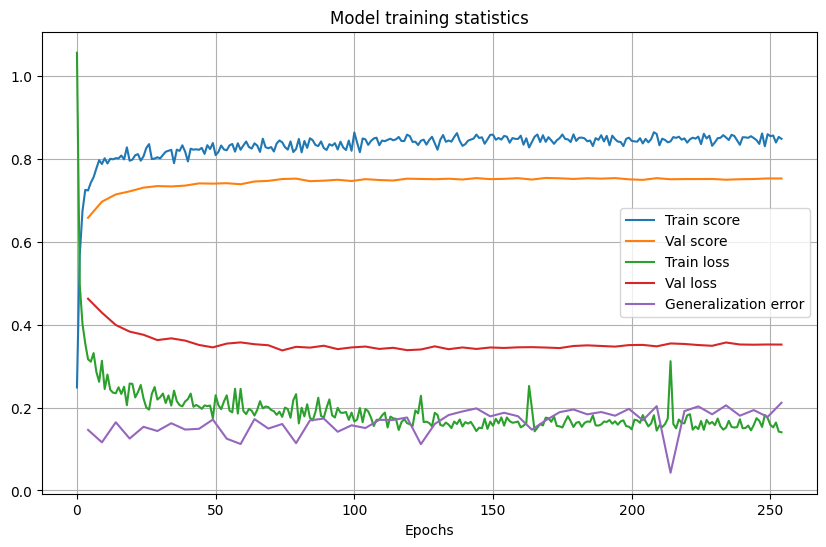

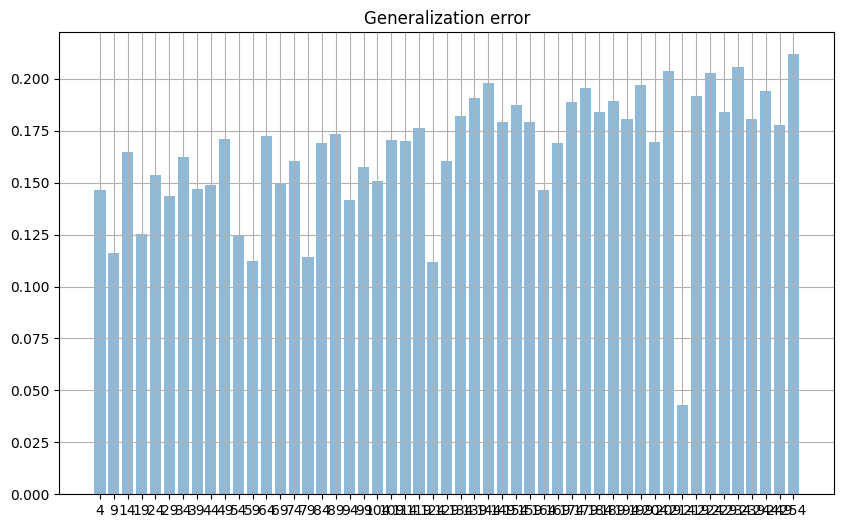

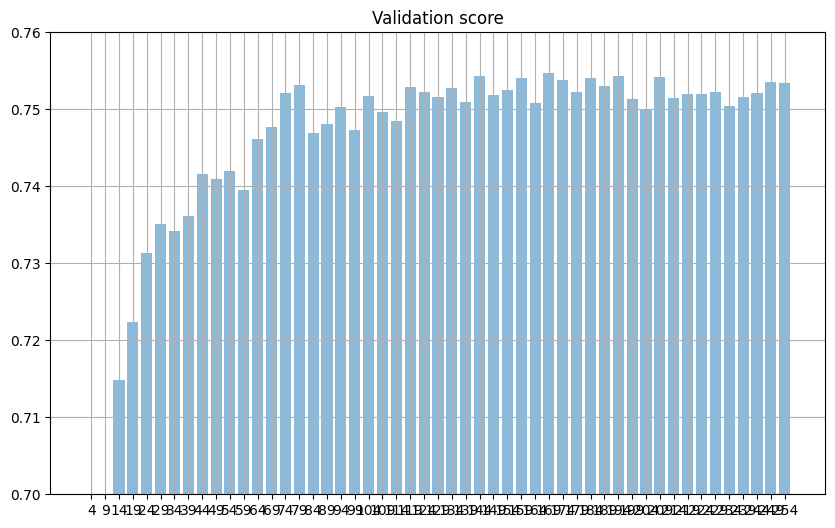

In [3]:
data = read_scores(file='mvfusion_3d_submission/batchsize6_nviews6_maxpoints200000.out')
plot_graph(data, log_scale=False)

# Generalization error
val_range = range(4, len(data['train_losses']) - len(data['train_losses']) % 5, 5)
gen_error = np.array(data['val_losses']) - np.array([data['train_losses'][i] for i in val_range])
plot_barchart(val_range, gen_error, 'Generalization error')
plot_barchart(val_range, data['val_scores'], 'Validation score', ylim=[0.7, 0.76])

#### Previously submitted model (M1)

M1


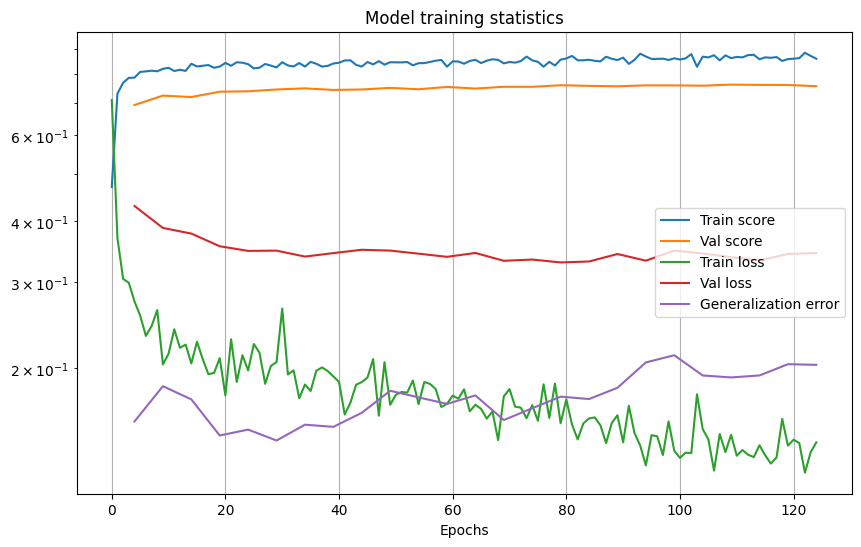

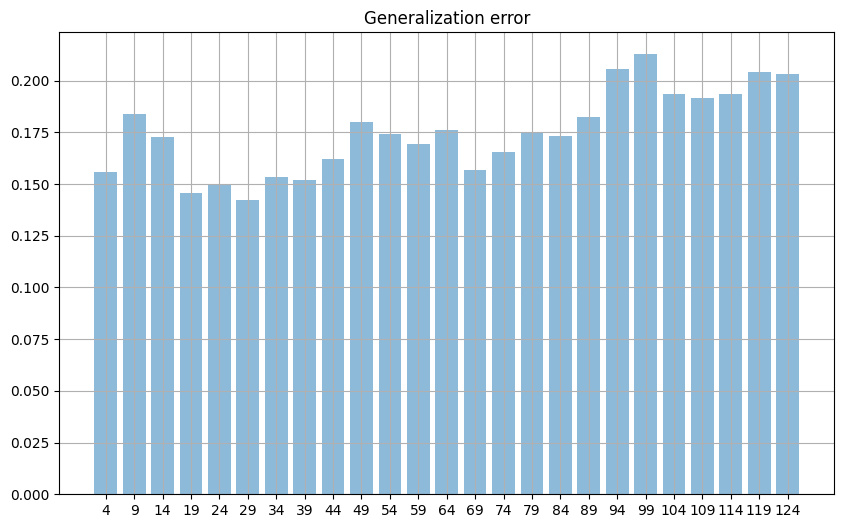

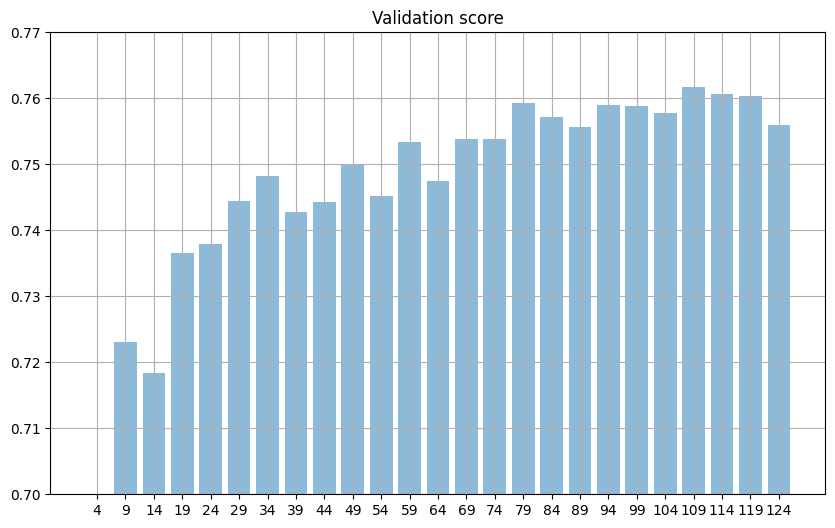

In [4]:
for i in range(1, 2):
    print(f"M{i}")
    data = read_scores(file=f'mvfusion_3d/model_comparison/M{i}.out')
    plot_graph(data, log_scale=True)

    # Generalization error
    val_range = range(4, len(data['train_losses']) - len(data['train_losses']) % 5, 5)
    gen_error = np.array(data['val_losses']) - np.array([data['train_losses'][i] for i in val_range])
    plot_barchart(val_range, gen_error, 'Generalization error')
    plot_barchart(val_range, data['val_scores'], 'Validation score', ylim=[0.7, 0.77])

# Superconvergence

### Part 1. LR range test (SGD with momentum, wd 1e-4)

In [5]:
# Looked good, take max_lr around 0.3 or lower

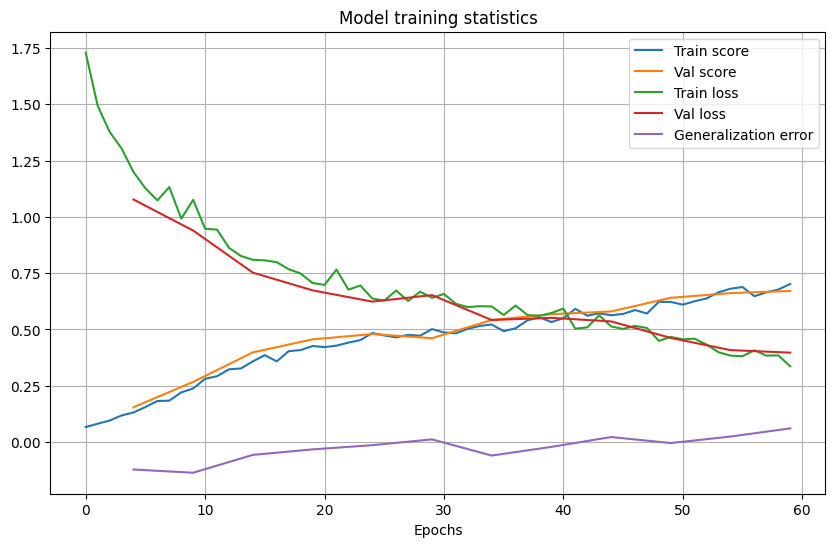

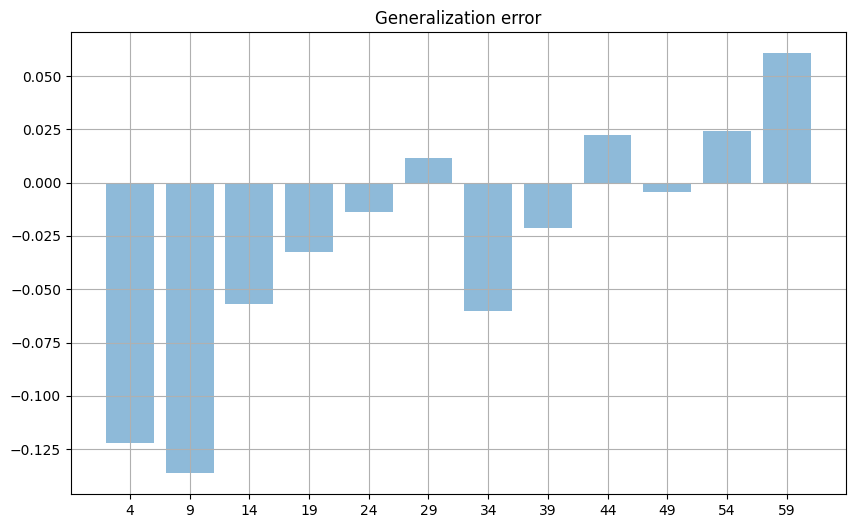

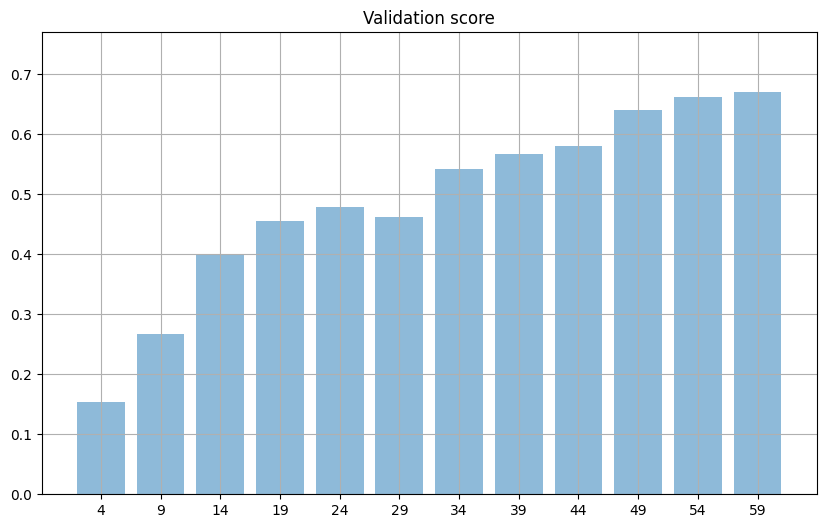

In [6]:
# 3D only
data = read_scores(file='superconvergence/3d_only/train_sgd_wd1e-4_lr0.3.out')
plot_graph(data, log_scale=False)

# Generalization error
val_range = range(4, len(data['train_losses']) - len(data['train_losses']) % 5, 5)
gen_error = np.array(data['val_losses']) - np.array([data['train_losses'][i] for i in val_range])
plot_barchart(val_range, gen_error, 'Generalization error')
plot_barchart(val_range, data['val_scores'], 'Validation score', ylim=[0.0, 0.77])

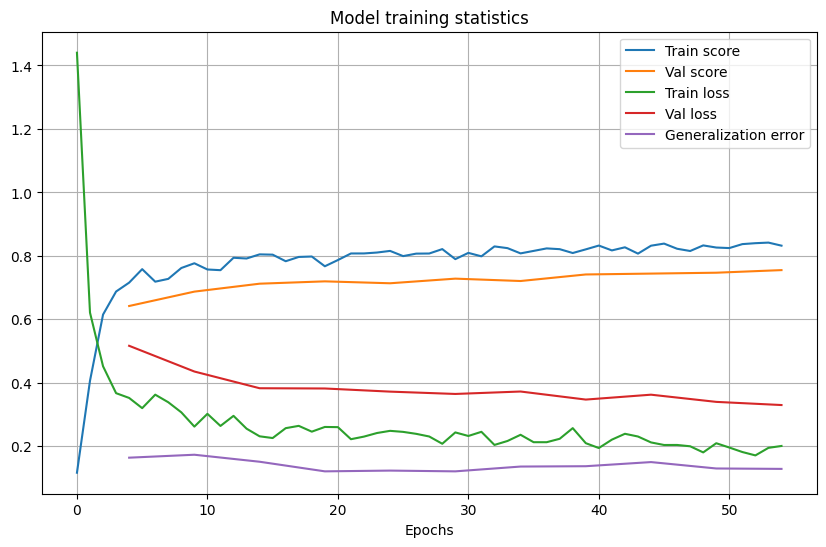

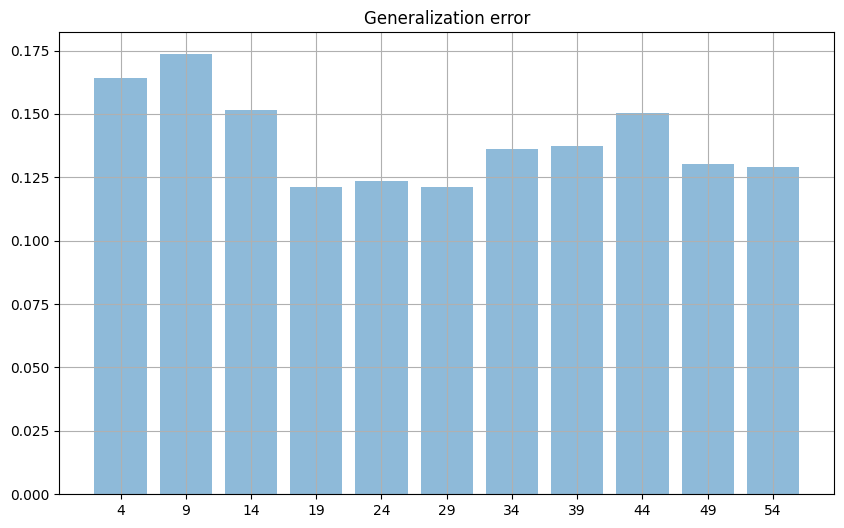

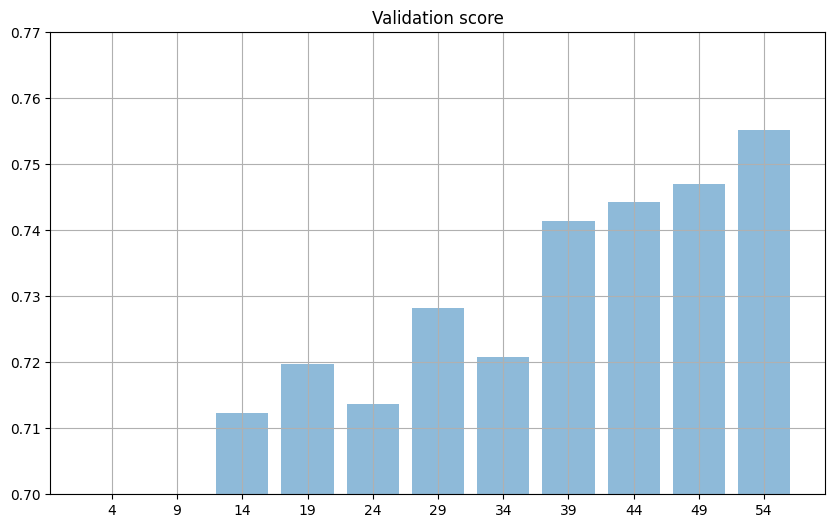

In [7]:
# MVFusion_3D_small

data = read_scores(file='superconvergence/train_sgd_wd1e-4_lr0.3.out')
plot_graph(data, log_scale=False)

# Generalization error
val_range = range(4, len(data['train_losses']) - len(data['train_losses']) % 5, 5)
gen_error = np.array(data['val_losses']) - np.array([data['train_losses'][i] for i in val_range])
plot_barchart(val_range, gen_error, 'Generalization error')
plot_barchart(val_range, data['val_scores'], 'Validation score', ylim=[0.7, 0.77])

# gradient flow: https://jupyter.lisa.surfsara.nl/2021/user/fsun/view/DeepViewAgg/outputs/2022-11-22/20-41-13/gradient_flow.png

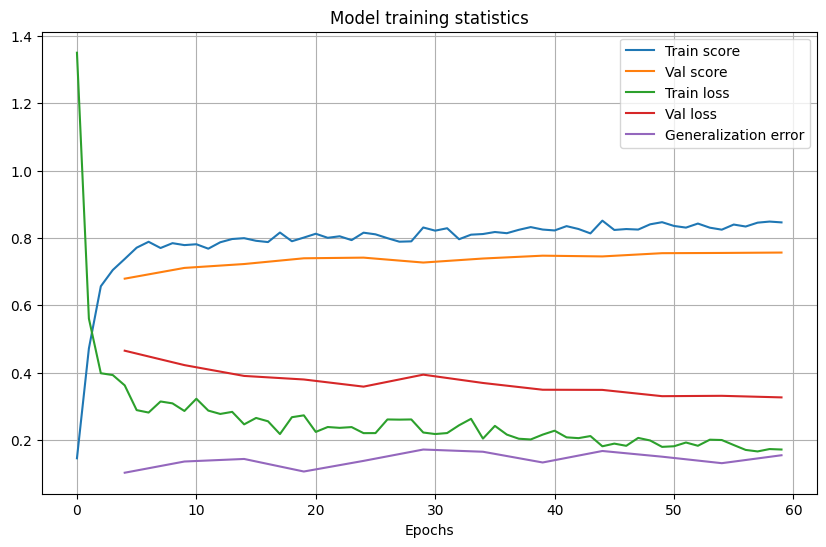

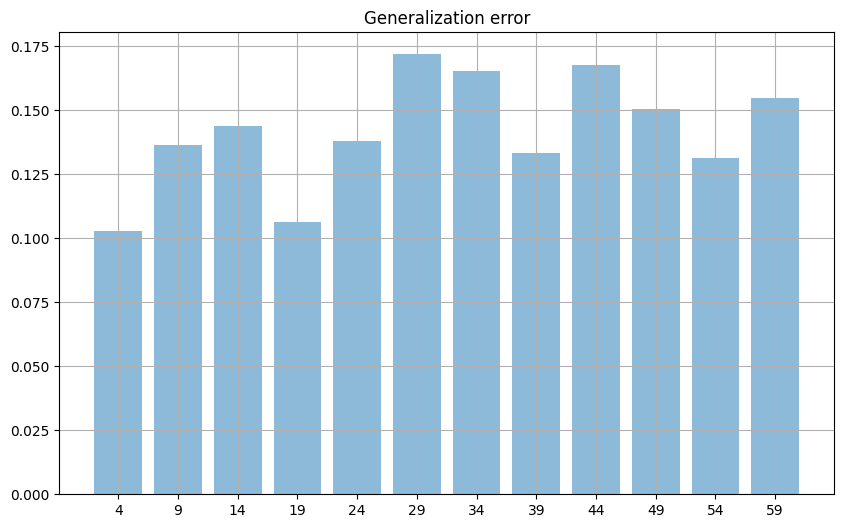

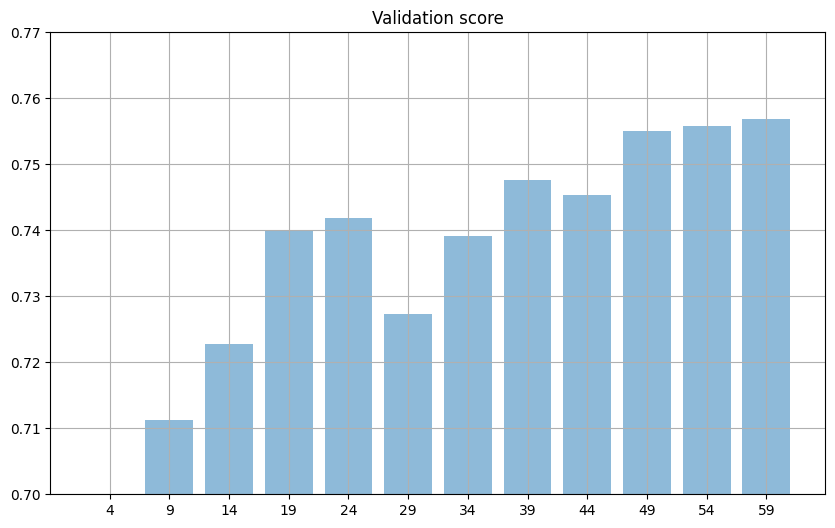

In [8]:
# MVFusion_3D_medium

data = read_scores(file='superconvergence/MVFusion_3D_medium/train_sgd_wd1e-4_lr0.3.out')
plot_graph(data, log_scale=False)

# Generalization error
val_range = range(4, len(data['train_losses']) - len(data['train_losses']) % 5, 5)
gen_error = np.array(data['val_losses']) - np.array([data['train_losses'][i] for i in val_range])
plot_barchart(val_range, gen_error, 'Generalization error')
plot_barchart(val_range, data['val_scores'], 'Validation score', ylim=[0.7, 0.77])

# gradient flow: https://jupyter.lisa.surfsara.nl/2021/user/fsun/view/DeepViewAgg/outputs/2022-11-22/20-41-13/gradient_flow.png

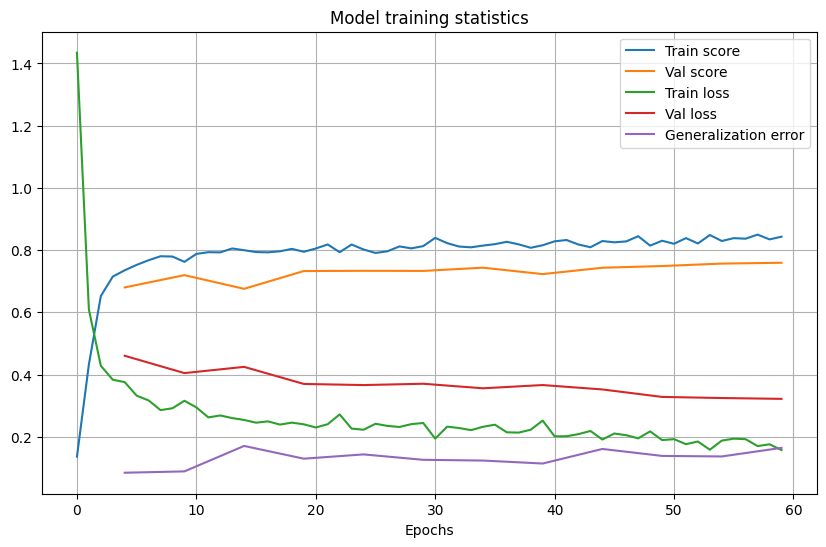

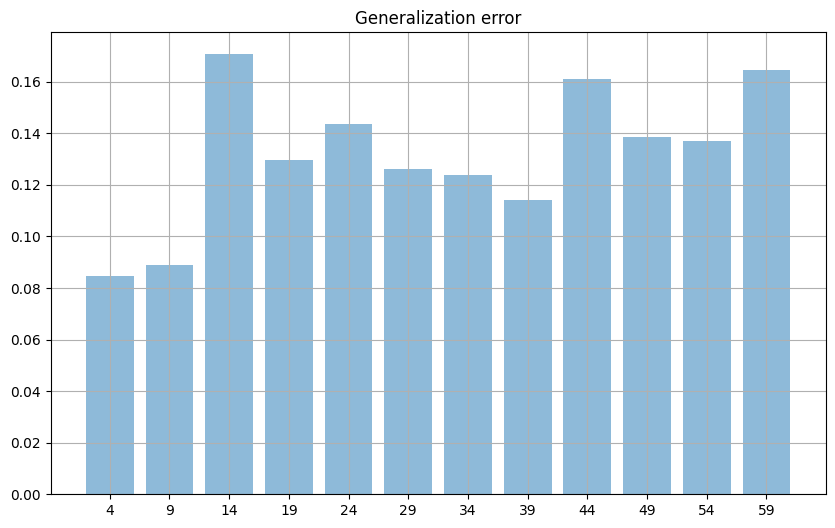

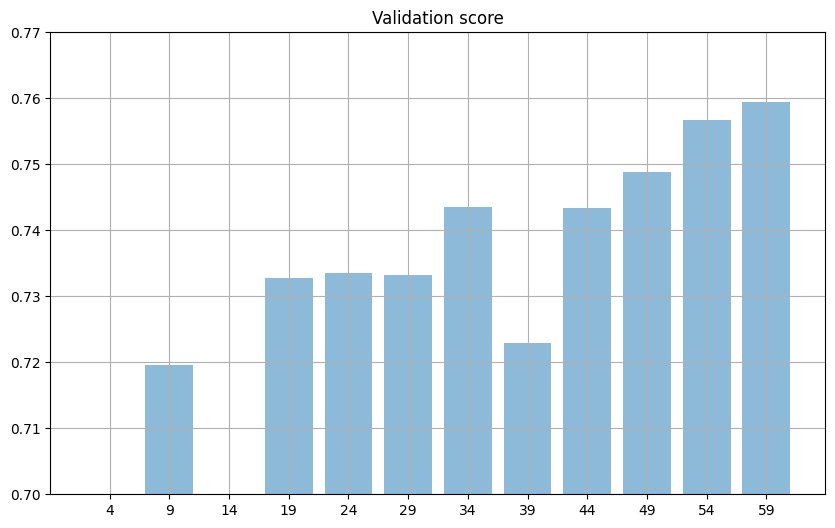

In [9]:
# MVFusion_3D_large

data = read_scores(file='superconvergence/MVFusion_3D_large/train_sgd_wd1e-4_lr0.3.out')
plot_graph(data, log_scale=False)

# Generalization error
val_range = range(4, len(data['train_losses']) - len(data['train_losses']) % 5, 5)
gen_error = np.array(data['val_losses']) - np.array([data['train_losses'][i] for i in val_range])
plot_barchart(val_range, gen_error, 'Generalization error')
plot_barchart(val_range, data['val_scores'], 'Validation score', ylim=[0.7, 0.77])

# gradient flow: https://jupyter.lisa.surfsara.nl/2021/user/fsun/view/DeepViewAgg/outputs/2022-11-22/20-41-13/gradient_flow.png

### Need to rerun gating with proper learning rate scheduler

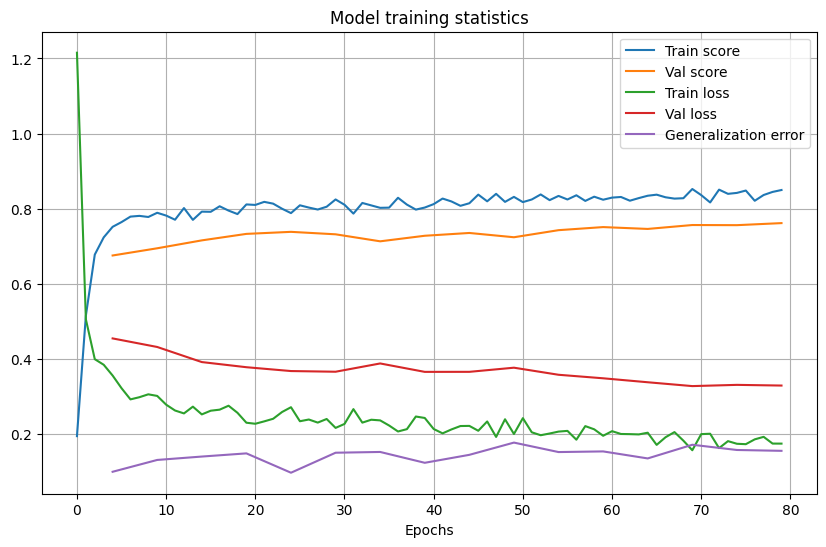

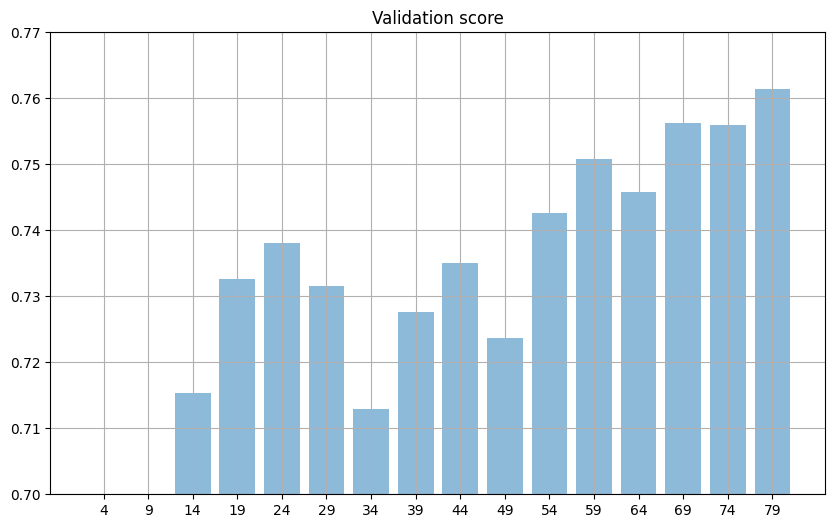

In [10]:
# MVFusion medium 80 epochs
data = read_scores(file='superconvergence/MVFusion_3D_medium/80_epochs_2nd_run.out')
plot_graph(data, log_scale=False)

# Generalization error
val_range = range(4, len(data['train_losses']) - len(data['train_losses']) % 5, 5)
gen_error = np.array(data['val_losses']) - np.array([data['train_losses'][i] for i in val_range])
# plot_barchart(val_range, gen_error, 'Generalization error')
plot_barchart(val_range, data['val_scores'], 'Validation score', ylim=[0.7, 0.77])

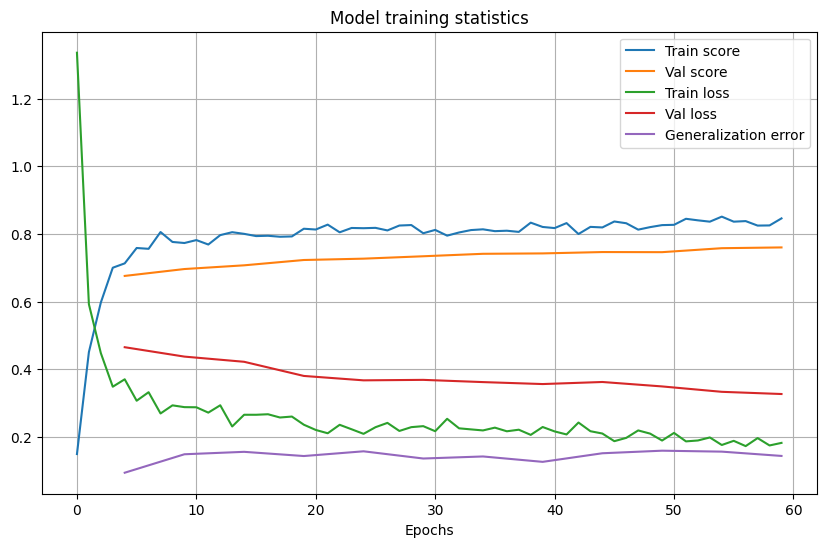

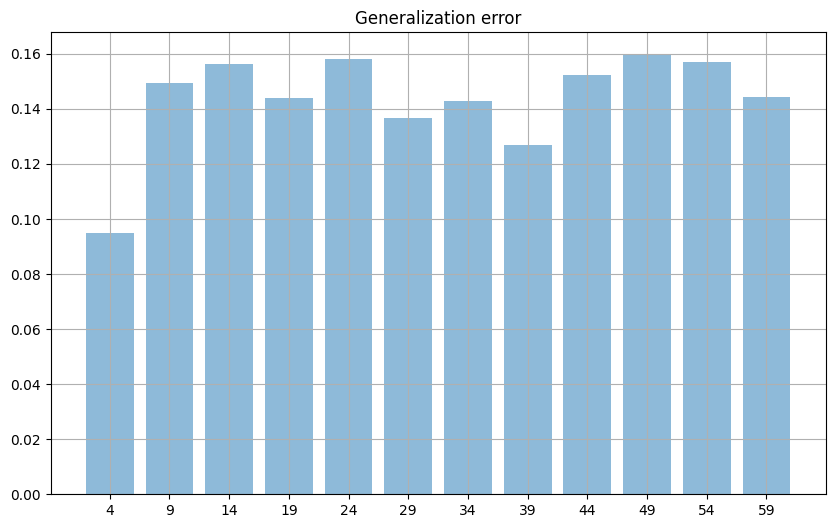

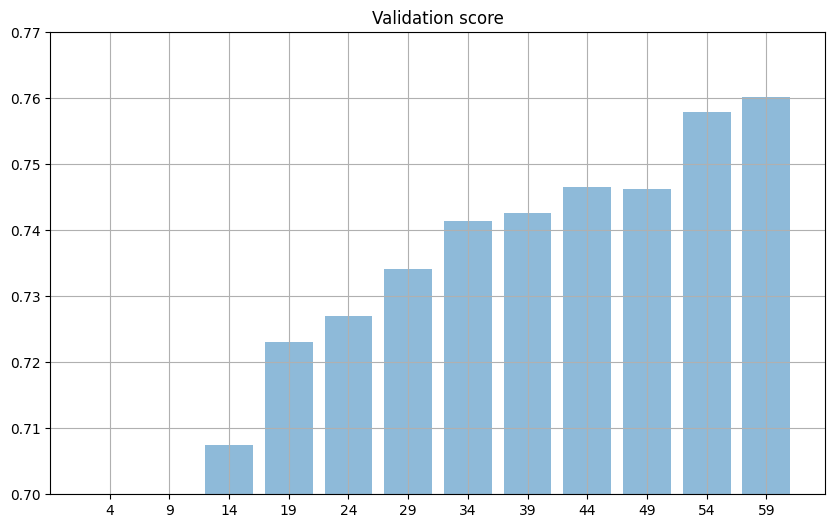

Max val score:  0.7602615828789723


In [11]:
# MVFusion 3D small default config
data = read_scores(file='superconvergence/MVFusion_3D_small/default_2nd_run.out')
plot_graph(data, log_scale=False)

# Generalization error
val_range = range(4, len(data['train_losses']) - len(data['train_losses']) % 5, 5)
gen_error = np.array(data['val_losses']) - np.array([data['train_losses'][i] for i in val_range])
plot_barchart(val_range, gen_error, 'Generalization error')
plot_barchart(val_range, data['val_scores'], 'Validation score', ylim=[0.7, 0.77])
print("Max val score: ", max(data['val_scores']))

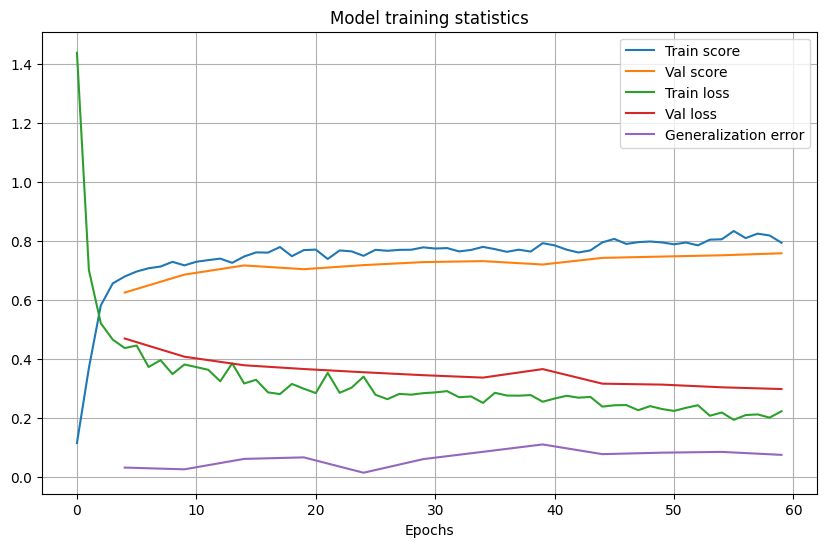

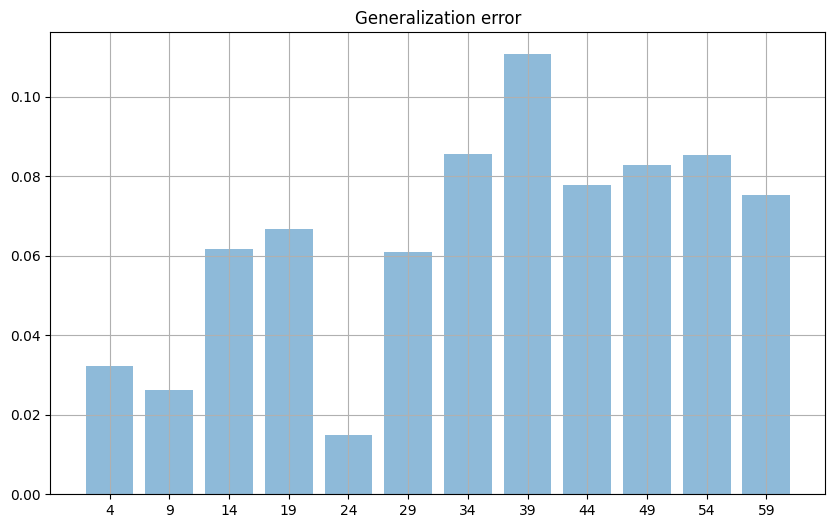

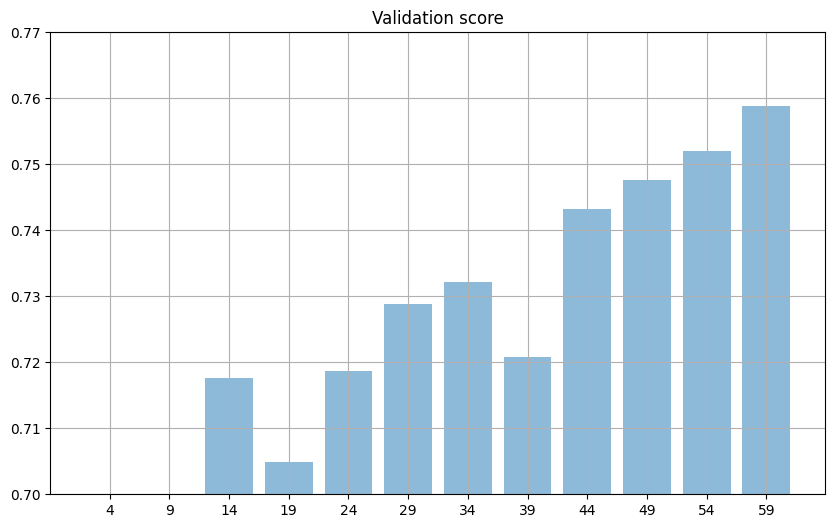

Max val score:  0.7588352236917505


In [12]:
# MVFusion 3D small, using swin_l_early masks
data = read_scores(file='superconvergence/MVFusion_3D_small/m2f_swin_l_early_2nd_run.out')
plot_graph(data, log_scale=False)

# Generalization error
val_range = range(4, len(data['train_losses']) - len(data['train_losses']) % 5, 5)
gen_error = np.array(data['val_losses']) - np.array([data['train_losses'][i] for i in val_range])
plot_barchart(val_range, gen_error, 'Generalization error')
plot_barchart(val_range, data['val_scores'], 'Validation score', ylim=[0.7, 0.77])
print("Max val score: ", max(data['val_scores']))

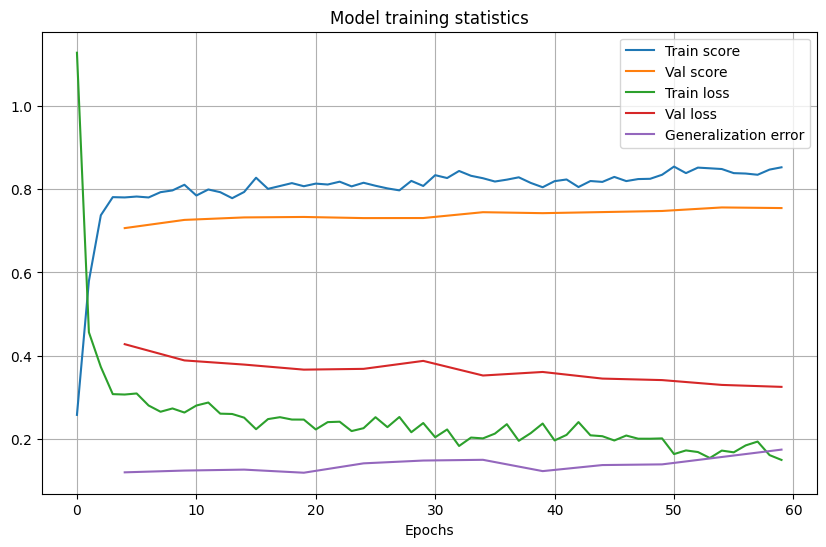

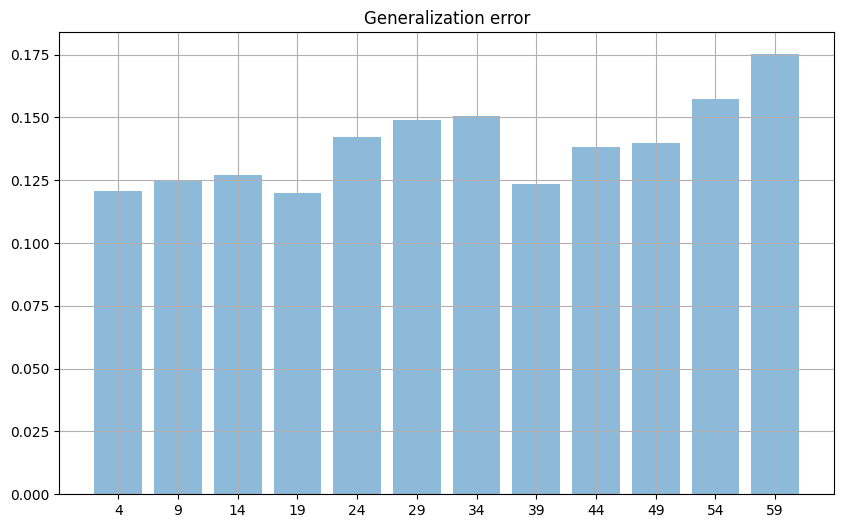

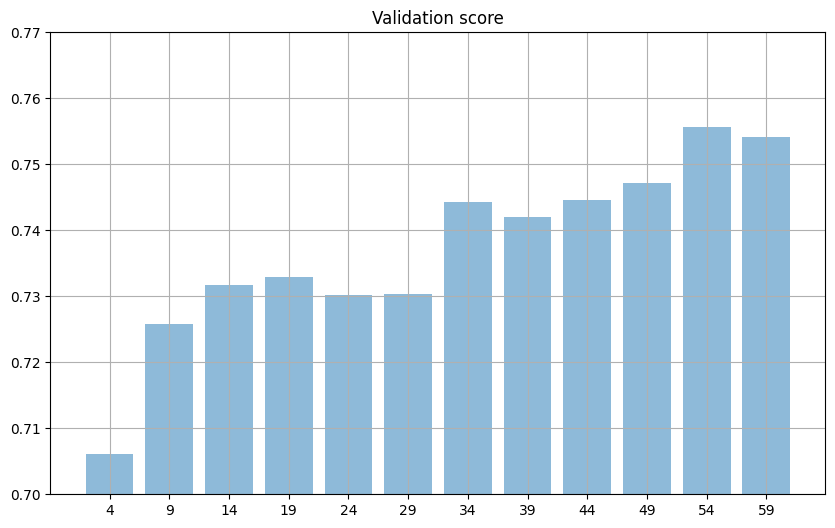

In [13]:
# MVAttention_3D_small
data = read_scores(file='superconvergence/MVAttention_3D_small/mvattention_baseline_2nd_run.out')
plot_graph(data, log_scale=False)

# Generalization error
val_range = range(4, len(data['train_losses']) - len(data['train_losses']) % 5, 5)
gen_error = np.array(data['val_losses']) - np.array([data['train_losses'][i] for i in val_range])
plot_barchart(val_range, gen_error, 'Generalization error')
plot_barchart(val_range, data['val_scores'], 'Validation score', ylim=[0.7, 0.77])

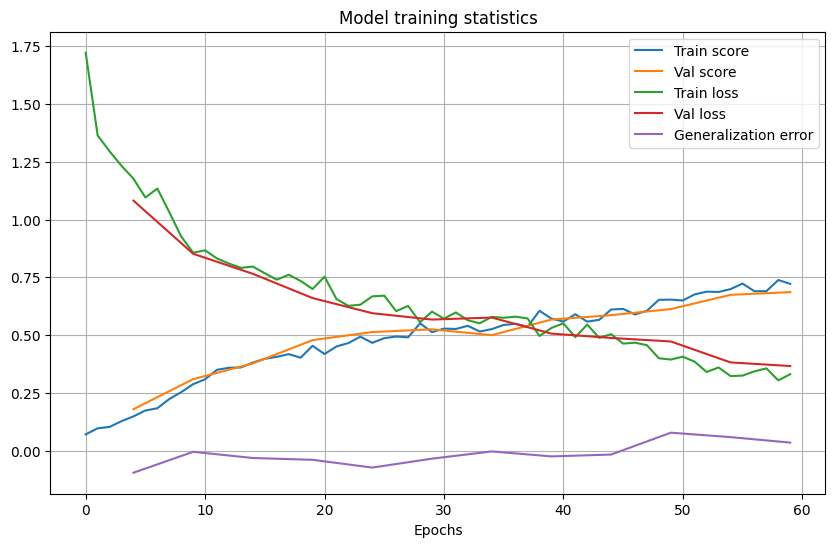

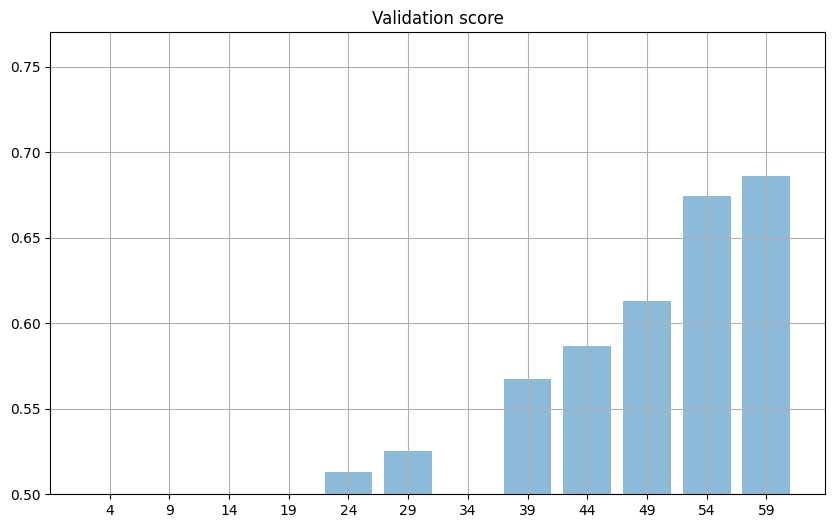

In [14]:
# MVFusion small no M2F
data = read_scores(file='superconvergence/MVFusion_3D_small/no_m2f_labels_2nd_run.out')
plot_graph(data, log_scale=False)

# Generalization error
val_range = range(4, len(data['train_losses']) - len(data['train_losses']) % 5, 5)
gen_error = np.array(data['val_losses']) - np.array([data['train_losses'][i] for i in val_range])
# plot_barchart(val_range, gen_error, 'Generalization error')
plot_barchart(val_range, data['val_scores'], 'Validation score', ylim=[0.5, 0.77])

# Gating vs no Gating (MVFusion_3D_medium)

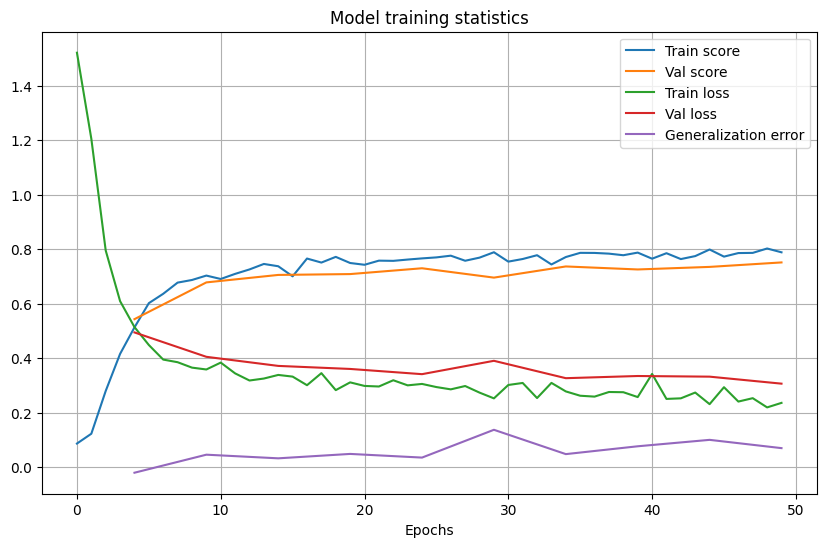

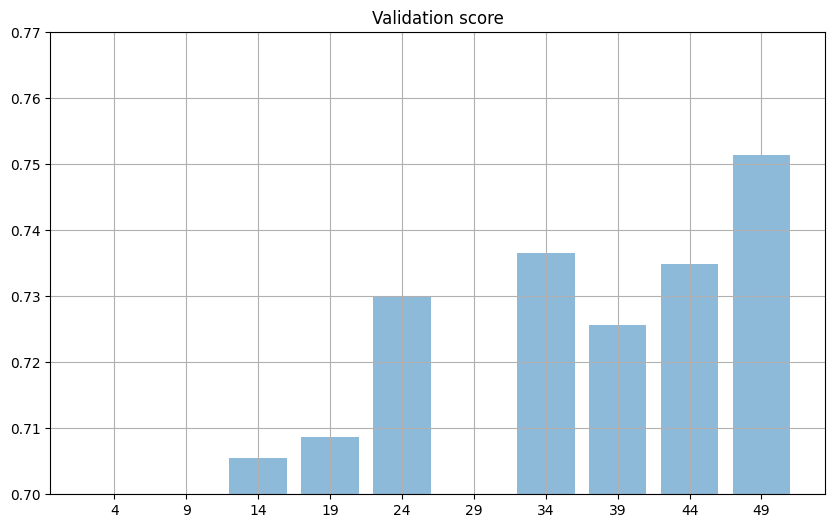

Max val score:  0.7513489086751477


In [15]:
# Gating
data = read_scores(file='superconvergence/MVFusion_3D_medium/gating_60epochs_swin_l_early.out')
plot_graph(data, log_scale=False)

# Generalization error
val_range = range(4, len(data['train_losses']) - len(data['train_losses']) % 5, 5)
gen_error = np.array(data['val_losses']) - np.array([data['train_losses'][i] for i in val_range])
# plot_barchart(val_range, gen_error, 'Generalization error')
plot_barchart(val_range, data['val_scores'], 'Validation score', ylim=[0.7, 0.77])
print("Max val score: ", max(data['val_scores']))

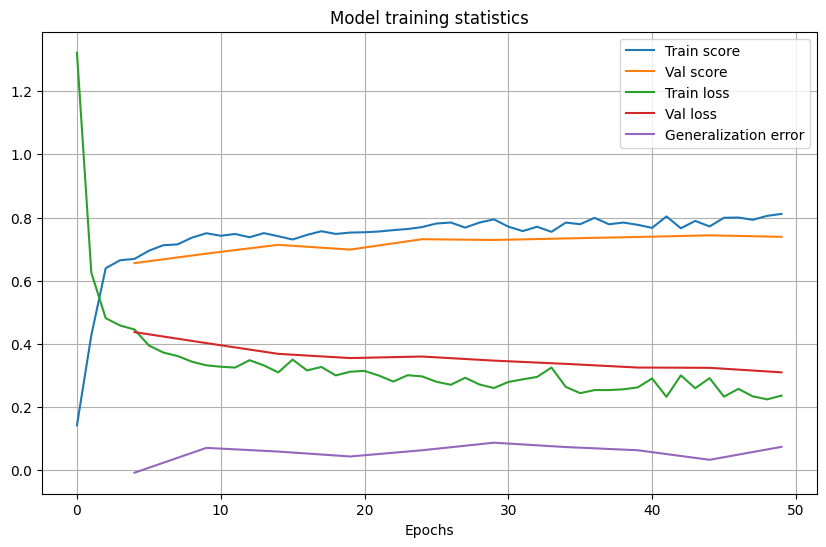

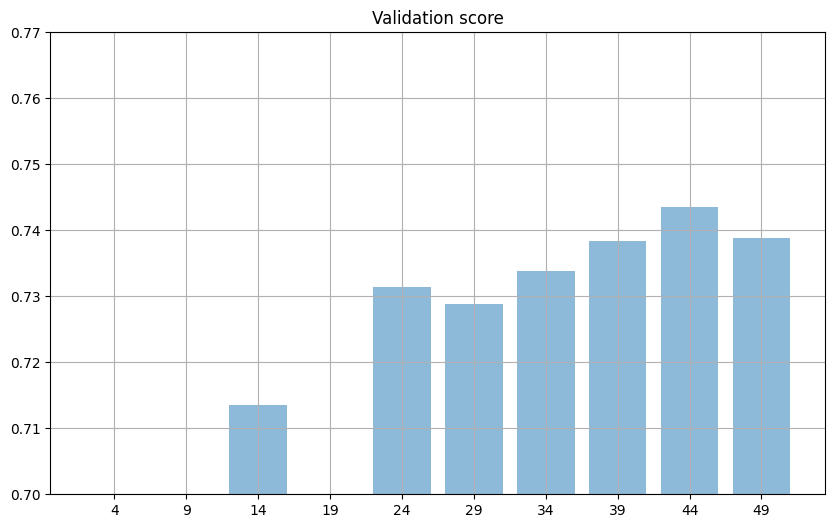

Max val score:  0.7435932764818276


In [16]:
# No gating
data = read_scores(file='superconvergence/MVFusion_3D_medium/60epochs_swin_l_early.out')
plot_graph(data, log_scale=False)

# Generalization error
val_range = range(4, len(data['train_losses']) - len(data['train_losses']) % 5, 5)
gen_error = np.array(data['val_losses']) - np.array([data['train_losses'][i] for i in val_range])
# plot_barchart(val_range, gen_error, 'Generalization error')
plot_barchart(val_range, data['val_scores'], 'Validation score', ylim=[0.7, 0.77])
print("Max val score: ", max(data['val_scores']))

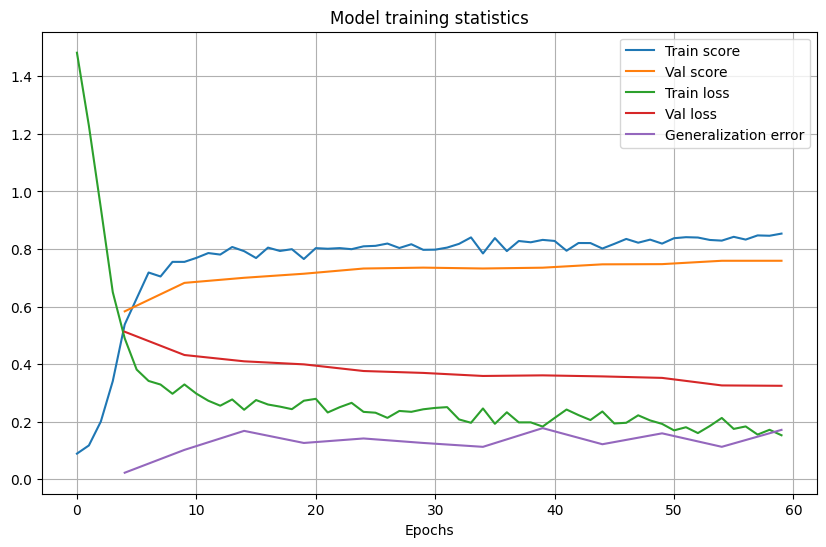

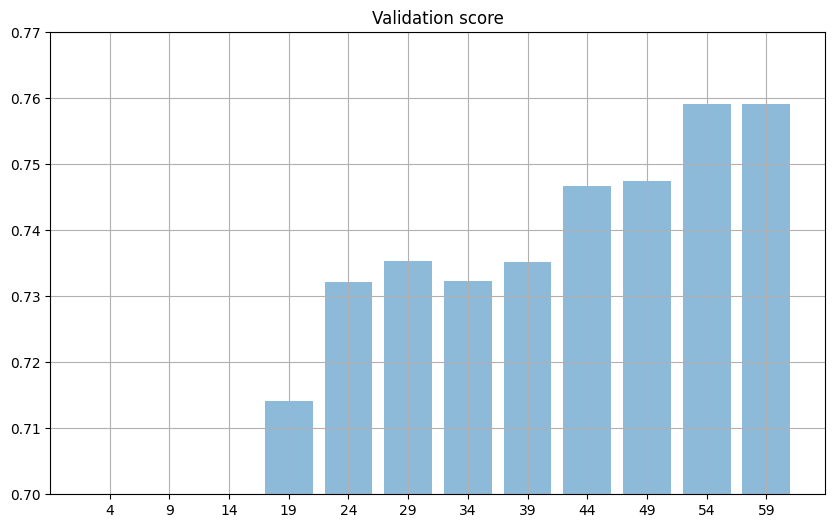

Max val score:  0.7591571912651617


In [17]:
# MVFusion_3D_small/60epochs_m2f_masks_gating.out

data = read_scores(file='superconvergence/MVFusion_3D_small/60epochs_m2f_masks_gating.out')
plot_graph(data, log_scale=False)

# Generalization error
val_range = range(4, len(data['train_losses']) - len(data['train_losses']) % 5, 5)
gen_error = np.array(data['val_losses']) - np.array([data['train_losses'][i] for i in val_range])
# plot_barchart(val_range, gen_error, 'Generalization error')
plot_barchart(val_range, data['val_scores'], 'Validation score', ylim=[0.7, 0.77])
print("Max val score: ", max(data['val_scores']))

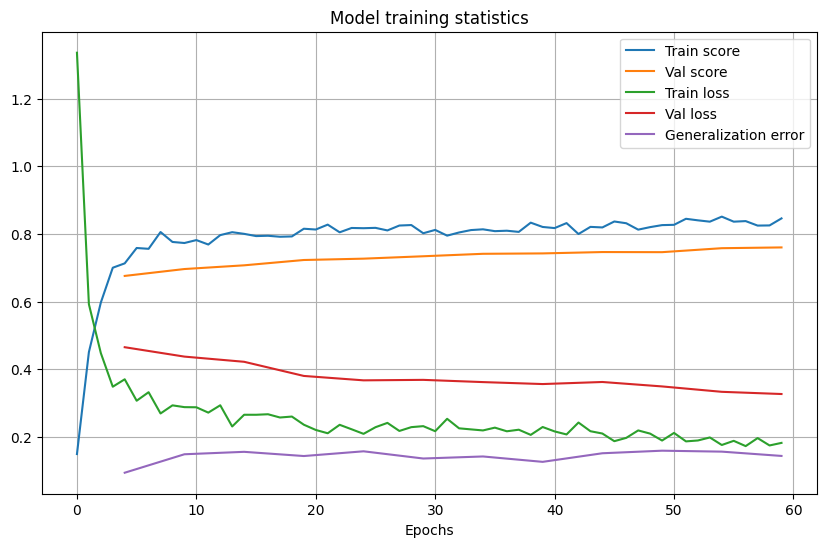

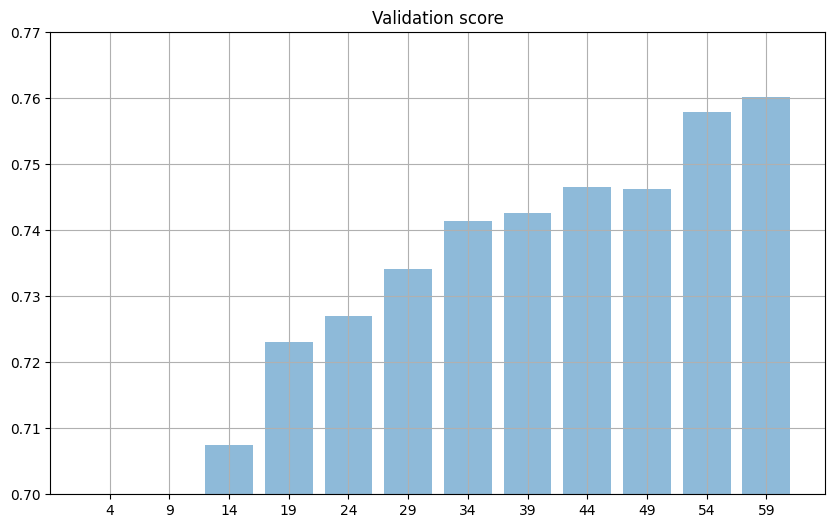

Max val score:  0.7602615828789723


In [18]:
# MVFusion_3D_small default 

data = read_scores(file='superconvergence/MVFusion_3D_small/default_2nd_run.out')
plot_graph(data, log_scale=False)

# Generalization error
val_range = range(4, len(data['train_losses']) - len(data['train_losses']) % 5, 5)
gen_error = np.array(data['val_losses']) - np.array([data['train_losses'][i] for i in val_range])
# plot_barchart(val_range, gen_error, 'Generalization error')
plot_barchart(val_range, data['val_scores'], 'Validation score', ylim=[0.7, 0.77])
print("Max val score: ", max(data['val_scores']))

In [3]:
# The following models used: m2f_masks
MVFusion_3D_small = [
    'MVFusion_3D_small/default_2nd_run.out',
    'MVFusion_3D_small/default_3rd_run.out'

]

MVFusion_3D_small_gating = [
    'MVFusion_3D_small/60epochs_m2f_masks_gating.out',
    'MVFusion_3D_small/60epochs_m2f_masks_gating_2nd_run.out'
]

MVFusion_3D_small_no_m2f_labels = [
    'MVFusion_3D_small/no_m2f_labels_2nd_run.out'
]

MVFusion_3D_medium = [
    'MVFusion_3D_medium/80_epochs_2nd_run.out',
    'MVFusion_3D_medium/80_epochs_3rd_run.out',
]

MVFusion_3D_medium_gating = [
    'MVFusion_3D_medium/80_epochs_gating.out'
]

MVAttention_3D_small = [
    'MVAttention_3D_small/mvattention_baseline_2nd_run.out'
]

Res16UNet34 = [
    '3d_only/train_sgd_wd1e-4_lr0.3.out'
]

MVFusion_3D_small_6views = [
    'MVFusion_3D_small/6_views.out'
]

MVFusion_3D_small_6views_nodropout = [
    'MVFusion_3D_small/MVFusion_3D_small_6views_nodropout.out'
]

MVFusion_3D_small_6views_RGB = [
    'MVFusion_3D_small/MVFusion_3D_small_6views_RGB.out'
]






all_models = [MVFusion_3D_small, MVFusion_3D_small_gating, MVFusion_3D_medium,
              MVFusion_3D_medium_gating, MVAttention_3D_small, MVFusion_3D_small_no_m2f_labels, Res16UNet34, 
              MVFusion_3D_small_6views, MVFusion_3D_small_6views_nodropout, MVFusion_3D_small_6views_RGB]

In [4]:
def plot_graph_error(data, log_scale=False):
    if len(data['train_scores'].shape) == 1:
        plot_graph(data, log_scale=log_scale)
        return
    
    plt.figure(figsize=(10,6))
    
    # Train

    train_scores = data['train_scores'].mean(axis=0)
    train_scores_err = data['train_scores'].std(axis=0)
    
    train_losses = data['train_losses'].mean(axis=0)
    train_losses_err = data['train_losses'].std(axis=0)
    
    train_x = range(len(train_scores))

    plt.plot(train_x, train_scores, color=colormap[0], label=f'Train score')
    plt.plot(train_x, train_losses, color=colormap[1], label=f'Train loss')

    plt.fill_between(train_x, train_scores-train_scores_err, train_scores+train_scores_err, alpha=0.5)
    plt.fill_between(train_x, train_losses-train_losses_err, train_losses+train_losses_err, alpha=0.5)



    # Validation
    # Pad validation metrics at x=0
    val_scores = np.concatenate(([0], data['val_scores'].mean(axis=0)), axis=0)
    val_scores_err = np.concatenate(([0], data['val_scores'].std(axis=0)), axis=0)

    val_losses = np.concatenate(([train_losses[0]], data['val_losses'].mean(axis=0)), axis=0)
    val_losses_err = np.concatenate(([train_scores_err[0]], data['val_losses'].std(axis=0)), axis=0)
    
    val_x = list(range(4, (len(train_scores) - len(train_scores) % 5), 5))
    val_x = [0] + val_x

    plt.plot(val_x, val_scores, color=colormap[2], label=f'Val score')
    plt.plot(val_x, val_losses, color=colormap[3], label=f'Val loss')

    plt.fill_between(val_x, val_scores-val_scores_err, val_scores+val_scores_err, alpha=0.5)
    plt.fill_between(val_x, val_losses-val_losses_err, val_losses+val_losses_err, alpha=0.5)

    

    # Plot generalization error
    gen_error = np.array(val_losses) - np.array([train_losses[i] for i in val_x])
    plt.plot(val_x, gen_error, color=colormap[4], label=f'Generalization error')


    
    
    plt.legend()
    plt.title('Model training statistics')
    plt.xlabel('Epochs')
    ax = plt.gca()
    if log_scale:
        ax.set_yscale('log')
    # ax.set_xlim([xmin, xmax])
    # ax.set_ylim([0.6, 0.9])
    plt.grid()

    plt.show()

Number of runs:  2
MVFusion_3D_small/default_3rd_run.out
Mean final val score:  75.96086640828808
Std dev:  0.06529187960914173


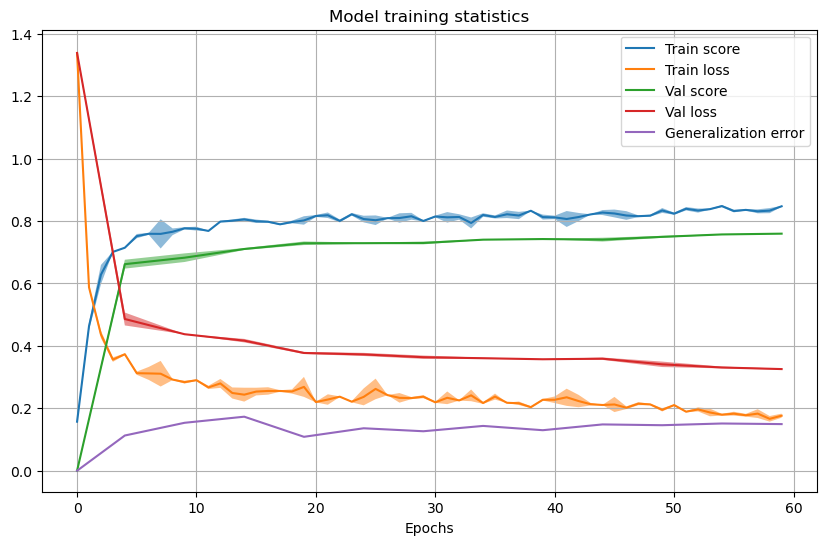

Number of runs:  2
MVFusion_3D_small/60epochs_m2f_masks_gating_2nd_run.out
Mean final val score:  75.65555562281365
Std dev:  0.2601635037025207


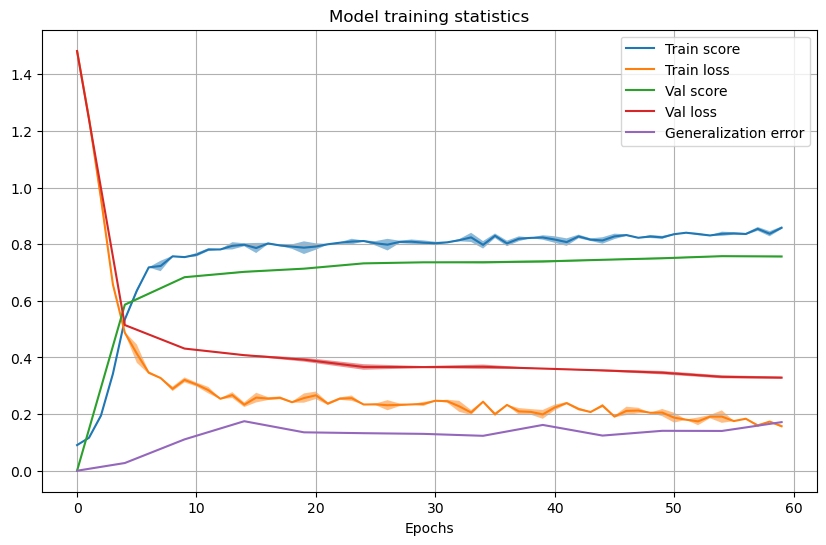

Number of runs:  2
MVFusion_3D_medium/80_epochs_3rd_run.out
Mean final val score:  75.92150649761093
Std dev:  0.21558503494106818


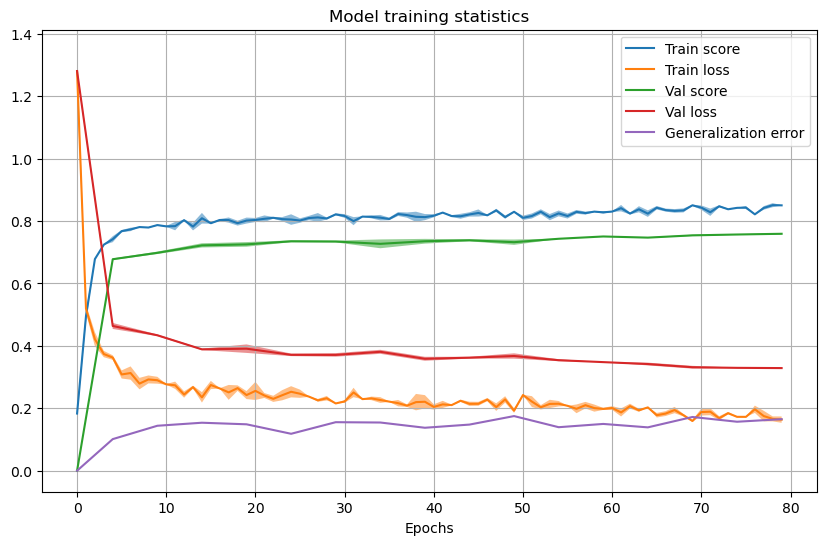

Number of runs:  1
MVFusion_3D_medium/80_epochs_gating.out
Final val score:  0.7606476831266338


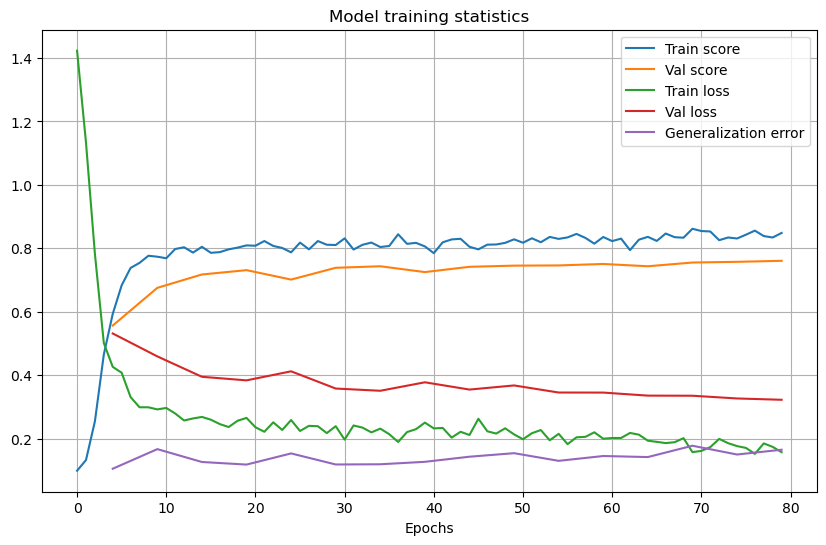

Number of runs:  1


FileNotFoundError: [Errno 2] No such file or directory: '/home/fsun/DeepViewAgg/job_logs/superconvergence/MVAttention_3D_small/mvattention_baseline_2nd_run.out'

In [5]:
indices = range(len(all_models))

for i in indices:
    datas = []
    print("Number of runs: ", len(all_models[i]))
    for fname in all_models[i]:
        datas.append(read_scores(file='superconvergence/' + fname))

    final_dict = {}
    for data in datas:
        for k, v in data.items():
            if k not in final_dict:
                final_dict[k] = np.array(v)
            else:
                final_dict[k] = np.vstack((final_dict[k], v))

    print(fname)
    try:
        print("Mean final val score: ", 100 * np.mean(final_dict['val_scores'][:, -1]))
        print("Std dev: ", 100 * np.std(final_dict['val_scores'][:, -1]))

    except IndexError:
        print("Final val score: ", np.mean(final_dict['val_scores'][-1]))
        
    plot_graph_error(final_dict, log_scale=False)

    #     # Generalization error
    #     val_range = range(4, len(data['train_losses']) - len(data['train_losses']) % 5, 5)
    #     gen_error = np.array(data['val_losses']) - np.array([data['train_losses'][i] for i in val_range])
    #     # plot_barchart(val_range, gen_error, 'Generalization error')
    #     plot_barchart(val_range, data['val_scores'], 'Validation score', ylim=[0.7, 0.77])

    
#     print(final_dict['val_scores'][:, -5:])

In [11]:
benchmark_models = [
    ['MVFusion_3D_small_6views_50epochs.out'],
    ['MVFusion_3D_small_6views_60epochs.out']
]

Number of runs:  1
MVFusion_3D_small_6views_50epochs.out


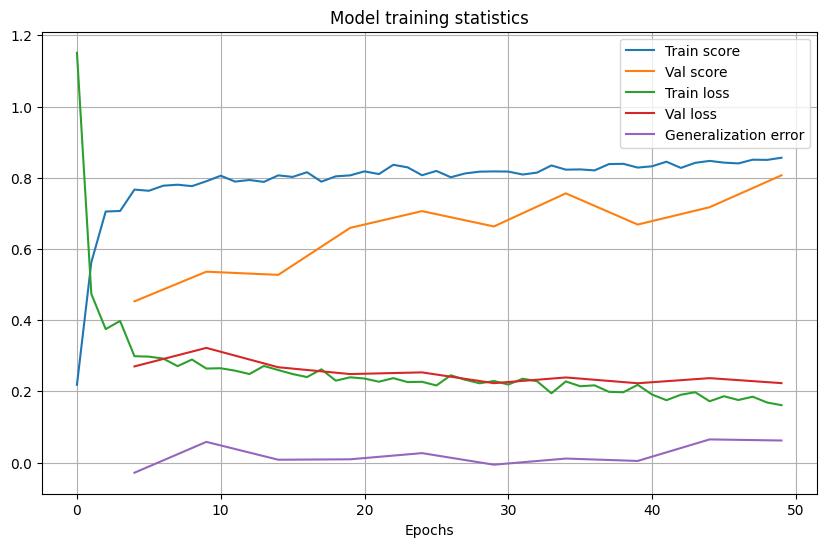

Max train score:  0.8561430637323306
Last train loss:  0.16119346079918054
Number of runs:  1
MVFusion_3D_small_6views_60epochs.out


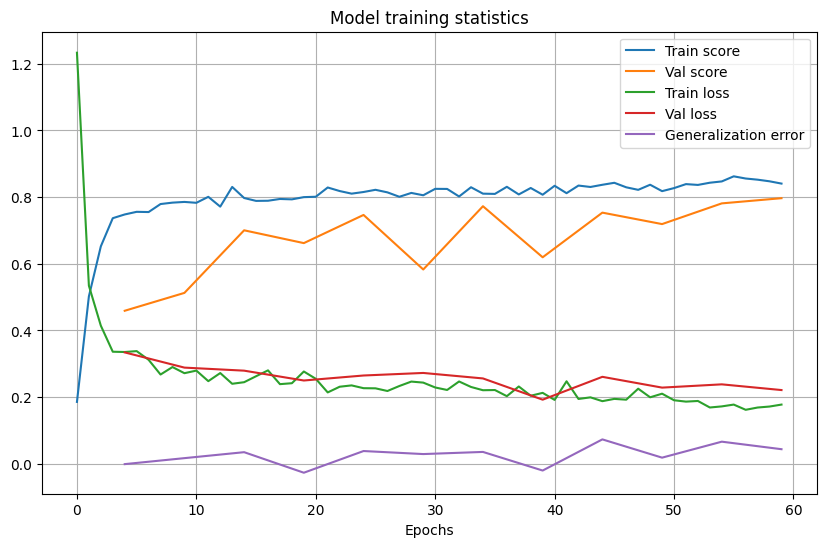

Max train score:  0.8623338918716521
Last train loss:  0.17745549260423732


In [12]:
for i in range(len(benchmark_models)):
    datas = []
    print("Number of runs: ", len(benchmark_models[i]))
    for fname in benchmark_models[i]:
        datas.append(read_scores(file='benchmark/' + fname))

    final_dict = {}
    for data in datas:
        for k, v in data.items():
            if k not in final_dict:
                final_dict[k] = np.array(v)
            else:
                final_dict[k] = np.vstack((final_dict[k], v))

    print(fname)
    plot_graph_error(final_dict, log_scale=False)

    #     # Generalization error
    #     val_range = range(4, len(data['train_losses']) - len(data['train_losses']) % 5, 5)
    #     gen_error = np.array(data['val_losses']) - np.array([data['train_losses'][i] for i in val_range])
    #     # plot_barchart(val_range, gen_error, 'Generalization error')
    #     plot_barchart(val_range, data['val_scores'], 'Validation score', ylim=[0.7, 0.77])
    print("Max train score: ", np.max(final_dict['train_scores']))
    print("Last train loss: ", final_dict['train_losses'][-1])
#     print(final_dict['train_scores'][:, -1])

In [14]:
ViT_MVFusion_3D_small_6views = ["MVFusion_3D_small/ViT_masks_run1.out",
                                "MVFusion_3D_small/ViT_masks_run2.out",
                                "MVFusion_3D_small/ViT_masks_run3.out",
]
ViT_MVFusion_3D_small_6views = [ViT_MVFusion_3D_small_6views]

Number of runs:  3
MVFusion_3D_small/ViT_masks_run3.out
Mean final val score:  77.41813687074416
Std dev:  0.17522544906893683


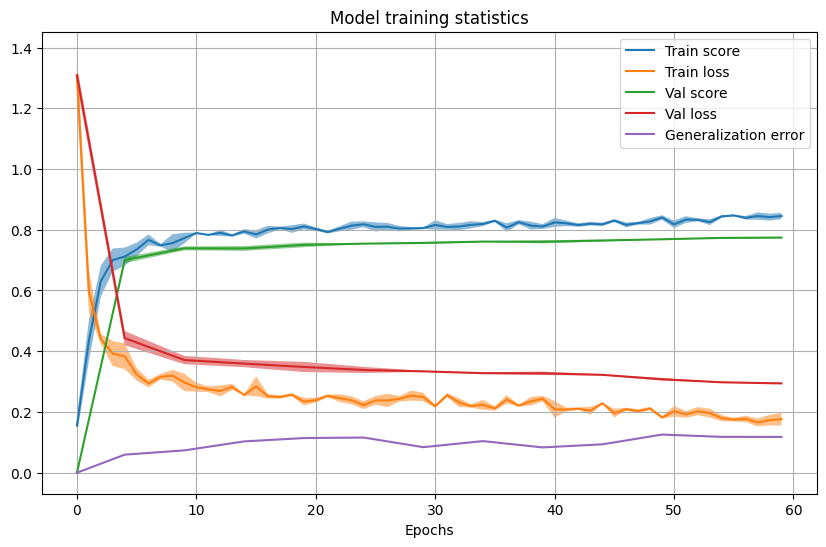

In [15]:
def plot_loss_2d_3d(data, log_scale=False):
    plt.figure(figsize=(10,6))
    
    # Train
    train_scores = data['train_loss_cross_entropy'].mean(axis=0)
    train_scores_err = data['train_loss_cross_entropy'].std(axis=0)
    
    train_losses = data['train_loss_2d_cross_entropy'].mean(axis=0)
    train_losses_err = data['train_loss_2d_cross_entropy'].std(axis=0)
    
    train_x = range(len(train_scores))

    plt.plot(train_x, train_scores, color=colormap[0], label=f'train_loss_3d_cross_entropy')
    plt.plot(train_x, train_losses, color=colormap[1], label=f'train_loss_2d_cross_entropy')

    plt.fill_between(train_x, train_scores-train_scores_err, train_scores+train_scores_err, alpha=0.5)
    plt.fill_between(train_x, train_losses-train_losses_err, train_losses+train_losses_err, alpha=0.5)

    # Validation
    # Pad validation metrics at x=0
    val_scores = np.concatenate(([train_scores[0]], data['val_loss_cross_entropy'].mean(axis=0)), axis=0)
    val_scores_err = np.concatenate(([train_scores_err[0]], data['val_loss_cross_entropy'].std(axis=0)), axis=0)

    val_losses = np.concatenate(([train_losses[0]], data['val_loss_2d_cross_entropy'].mean(axis=0)), axis=0)
    val_losses_err = np.concatenate(([train_losses_err[0]], data['val_loss_2d_cross_entropy'].std(axis=0)), axis=0)
    
    val_x = list(range(4, (len(train_scores) - len(train_scores) % 5), 5))
    val_x = [0] + val_x

    plt.plot(val_x, val_scores, color=colormap[2], label=f'val_loss_3d_cross_entropy')
    plt.plot(val_x, val_losses, color=colormap[3], label=f'val_loss_2d_cross_entropy')

    plt.fill_between(val_x, val_scores-val_scores_err, val_scores+val_scores_err, alpha=0.5)
    plt.fill_between(val_x, val_losses-val_losses_err, val_losses+val_losses_err, alpha=0.5)

    

#     # Plot generalization error
#     gen_error = np.array(val_losses) - np.array([train_losses[i] for i in val_x])
#     plt.plot(val_x, gen_error, color=colormap[4], label=f'Generalization error')


    
    
    plt.legend()
    plt.title('Model training statistics')
    plt.xlabel('Epochs')
    ax = plt.gca()
    if log_scale:
        ax.set_yscale('log')
    # ax.set_xlim([xmin, xmax])
    # ax.set_ylim([0.6, 0.9])
    plt.grid()
    plt.show()
    

def plot_training_graph(model_runs):
    indices = range(len(model_runs))
    for i in indices:
        datas = []
        print("Number of runs: ", len(model_runs[i]))
        for fname in model_runs[i]:
            datas.append(read_scores(file='superconvergence/' + fname))

        final_dict = {}
        for data in datas:
            for k, v in data.items():
                if k not in final_dict:
                    final_dict[k] = np.array(v)
                else:
                    final_dict[k] = np.vstack((final_dict[k], v))

                    
        print(fname)
        
        try:
            print("Mean final val score: ", 100 * np.mean(final_dict['val_scores'][:, -1]))
            print("Std dev: ", 100 * np.std(final_dict['val_scores'][:, -1]))

        except IndexError:
            print("Final val score: ", np.mean(final_dict['val_scores'][-1]))

        plot_graph_error(final_dict, log_scale=False)
        

        if final_dict['train_loss_2d_cross_entropy'].size > 0:
            plot_loss_2d_3d(final_dict, log_scale=False)

plot_training_graph(ViT_MVFusion_3D_small_6views)

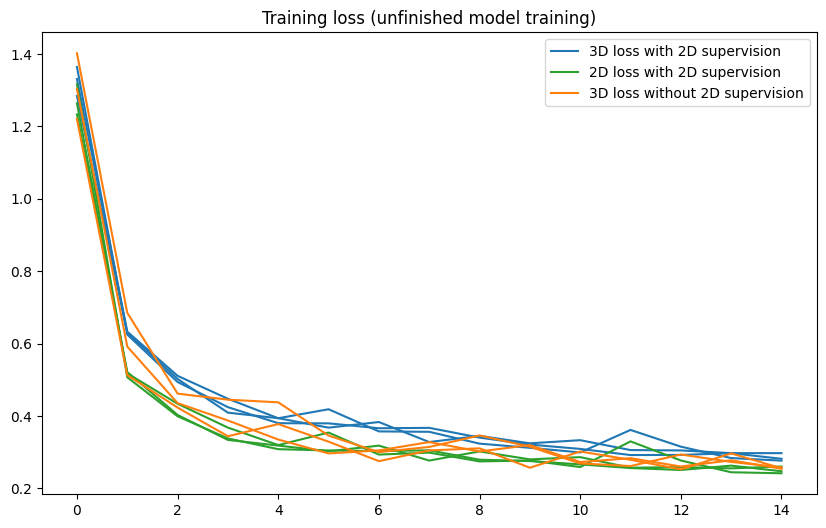

In [6]:
a = [1.3309593200683592, 0.633050537109375, 0.5110473170876502, 0.44766065478324885, 0.3938886746764183, 0.4187434121966362, 0.3575538255274296, 0.35643670633435254, 0.3237567707896232, 0.3122383221983909, 0.2994863100349903, 0.36161869168281563, 0.3154169864952564, 0.2838890671730041, 0.276807290315628]
b = [1.2842821002006533, 0.6304136618971825, 0.5023850992321968, 0.40930019766092307, 0.3940314739942551, 0.3679358124732971, 0.3834272235631943, 0.3281523548066616, 0.3453277535736561, 0.3246166646480561, 0.3333058349788189, 0.30599747821688655, 0.30496061891317366, 0.2975036203861236, 0.2975162453949452]
c = [1.3642663747072223, 0.6250794887542724, 0.49401146844029437, 0.4245289474725723, 0.38017606437206264, 0.37979175895452505, 0.3662771090865135, 0.3673335678875447, 0.34045594781637195, 0.32116678208112714, 0.3091925553977489, 0.29225520342588424, 0.29258051961660386, 0.2973042331635953, 0.2819169104099274]

a_seg = [1.263957001268864, 0.5178956255316733, 0.4339646711945534, 0.3680270619690418, 0.3197432324290276, 0.3543256923556327, 0.29354880452156074, 0.2989100925624371, 0.2746519379317761, 0.2771282717585563, 0.2590925082564354, 0.32999619990587226, 0.2772031843662262, 0.2447136335074902, 0.24188298434019093]
b_seg = [1.2330329164862632, 0.5213488548994063, 0.40295038819313045, 0.3339967966079712, 0.3183924354612827, 0.3026345163583755, 0.3182662963867188, 0.27700050622224803, 0.302262645214796, 0.280274100601673, 0.2864575952291489, 0.2571859106421471, 0.25900589823722836, 0.2554458290338516, 0.26061907932162287]
c_seg = [1.3165653109550475, 0.5070844113826751, 0.39934482425451273, 0.3380676507949829, 0.30844945311546323, 0.3049193702638149, 0.3031311579048634, 0.3052649609744549, 0.27937870994210245, 0.27561155259609227, 0.2664675772190094, 0.2563467144966126, 0.2510064013302326, 0.2630067303776741, 0.24747041910886763]

# for idx in [a, b, c]:
plt.figure(figsize=(10,6))


plt.plot(a, color=colormap[0])
plt.plot(b, color=colormap[0])
plt.plot(c, color=colormap[0], label='3D loss with 2D supervision')

plt.plot(a_seg, color=colormap[2])
plt.plot(b_seg, color=colormap[2])
plt.plot(c_seg, color=colormap[2], label='2D loss with 2D supervision')

plt.plot([1.30357535, 0.59194715, 0.43565982, 0.38764785, 0.33507693,
       0.29672755, 0.30504199, 0.32806023, 0.30215738, 0.31973019,
       0.27291013, 0.28358183, 0.26057101, 0.27770723, 0.25435247], color=colormap[1])

plt.plot([1.22045986, 0.51295976, 0.4233408 , 0.34414847, 0.37777174,
       0.32917805, 0.27537395, 0.3050073 , 0.3107953 , 0.2572086 ,
       0.3020722 , 0.2791976 , 0.25257013, 0.2967848 , 0.25568558], color=colormap[1])

plt.plot([1.40200437, 0.68517072, 0.46191953, 0.44514161, 0.43786872,
       0.34592923, 0.30024421, 0.31461982, 0.34633415, 0.31535968,
       0.26916057, 0.26180476, 0.29376016, 0.27325935, 0.25826107], color=colormap[1], label='3D loss without 2D supervision')
plt.title("Training loss (unfinished model training)")
plt.legend()
plt.show()

# # for idx in [a, b, c]:
# plt.figure(figsize=(10,6))
# plt.plot(a_seg, color=colormap[0])
# plt.plot(b_seg, color=colormap[0])
# plt.plot(c_seg, color=colormap[0], label='2D loss with 2D supervision')


# plt.plot([1.30357535, 0.59194715, 0.43565982, 0.38764785, 0.33507693,
#        0.29672755, 0.30504199, 0.32806023, 0.30215738, 0.31973019,
#        0.27291013, 0.28358183, 0.26057101, 0.27770723, 0.25435247], color=colormap[1])

# plt.plot([1.22045986, 0.51295976, 0.4233408 , 0.34414847, 0.37777174,
#        0.32917805, 0.27537395, 0.3050073 , 0.3107953 , 0.2572086 ,
#        0.3020722 , 0.2791976 , 0.25257013, 0.2967848 , 0.25568558], color=colormap[1])

# plt.plot([1.40200437, 0.68517072, 0.46191953, 0.44514161, 0.43786872,
#        0.34592923, 0.30024421, 0.31461982, 0.34633415, 0.31535968,
#        0.26916057, 0.26180476, 0.29376016, 0.27325935, 0.25826107], color=colormap[1], label='3D loss without 2D supervision')
# plt.title("2D/3D Training loss (unfinished model training)")
# plt.legend()
# plt.show()


Number of runs:  3
MVFusion_3D_small_6views_2d_supervision/ViT_masks_run_3.out
Mean final val score:  77.00012557603837
Std dev:  0.0772501619369806


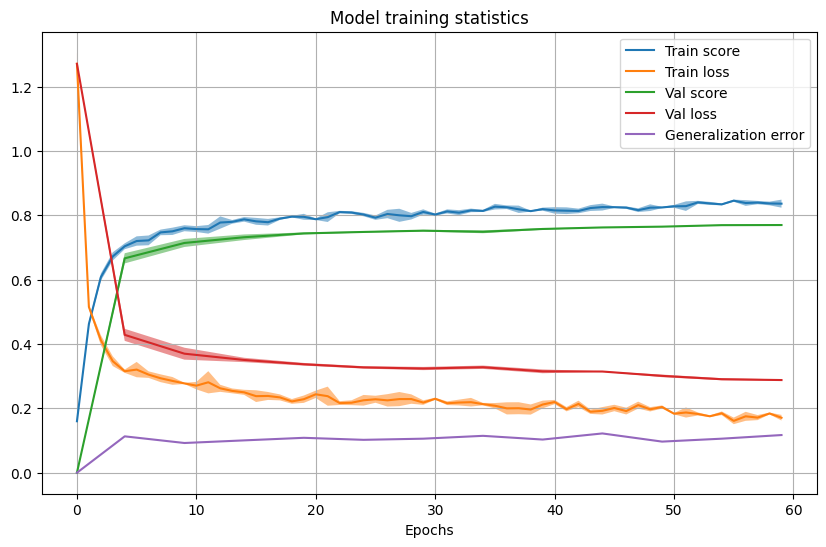

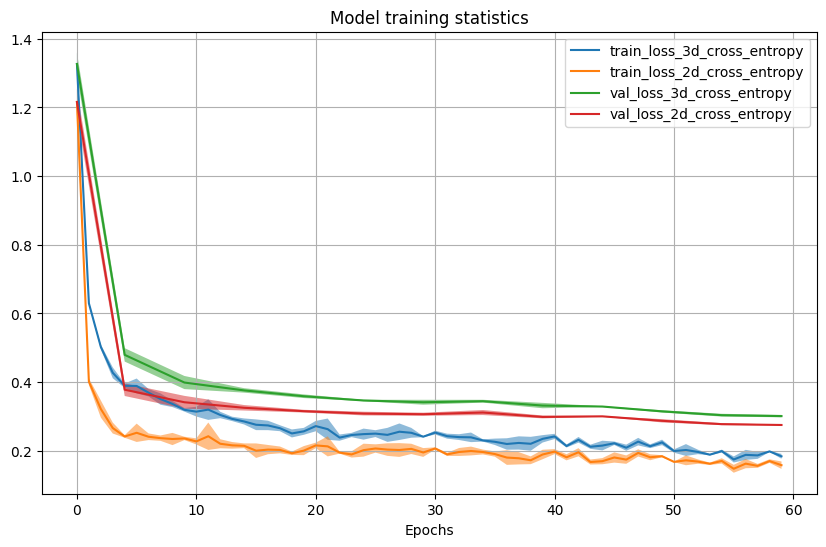

In [16]:
ViT_MVFusion_3D_small_6views_2d_supervision = [["MVFusion_3D_small_6views_2d_supervision/ViT_masks_run_1.out",
                                "MVFusion_3D_small_6views_2d_supervision/ViT_masks_run_2.out",
                                "MVFusion_3D_small_6views_2d_supervision/ViT_masks_run_3.out",
]]

plot_training_graph(ViT_MVFusion_3D_small_6views_2d_supervision)

In [ ]:
ViT_MVFusion_3D_small_6views_2d_supervision

## Read classwise scores and calculate statistics

In [19]:
import re
def read_class_scores(file):
    with open(f'/home/fsun/DeepViewAgg/job_logs/superconvergence/{file}') as f:
        lines = f.readlines()

        pattern = 'EPOCH 60 / 61'
        final_epoch_lines = [lines[i:] for i in range(len(lines)) if pattern in lines[i]][0]
        class_iou_scores = [line for line in final_epoch_lines if "2023-01-04" in line]
        
#         train_scores = [float(m.split()[-1]) / 100 for m in matching_lines]
    
#         print(final_epoch_lines)
        scores = re.split("{|}", class_iou_scores[-2])[1]
        print(scores)
        
        scores_list = []
        for pair in scores.split(","):
            k, v = pair.split(": ")
            k, v = int(k), float(v.replace("'", ""))
            
            scores_list.append(v)
            
        return scores_list
            
                
three_runs = [read_class_scores(ViT_MVFusion_3D_small_6views_2d_supervision[0][i]) for i in range(3)]
three_runs = np.array(three_runs)

print(np.mean(three_runs, 1))

mean_class_scores = np.round(np.mean(three_runs, axis=0), 2)
print("Mean class scores: \n", mean_class_scores)
print("Mean mIoU: \n", np.mean(mean_class_scores))
print("Std dev per class : \n", np.round(np.std(three_runs, axis=0), 2))

# Original
#  [87.59 96.52 72.49 84.79 92.06 83.41 79.54 74.48 74.   80.46 26.59 68.58
#  72.56 79.79 73.69 83.66 93.76 69.08 86.68 68.65]

# with 2d Supervision
#  [87.36 96.32 72.46 84.16 91.66 82.76 78.94 74.5  73.69 80.29 27.01 68.37
#  71.66 79.59 73.2  83.08 92.84 68.31 86.33 67.5 ]

0: '87.43', 1: '96.28', 2: '72.35', 3: '84.20', 4: '92.05', 5: '83.36', 6: '78.98', 7: '74.97', 8: '73.65', 9: '79.12', 10: '27.52', 11: '68.06', 12: '71.73', 13: '79.87', 14: '73.33', 15: '82.86', 16: '93.54', 17: '68.68', 18: '86.10', 19: '67.14'
0: '87.47', 1: '96.31', 2: '73.01', 3: '84.03', 4: '91.67', 5: '82.59', 6: '78.62', 7: '74.70', 8: '73.81', 9: '80.85', 10: '26.84', 11: '68.54', 12: '71.20', 13: '79.47', 14: '74.73', 15: '83.35', 16: '92.17', 17: '67.83', 18: '86.17', 19: '67.61'
0: '87.17', 1: '96.37', 2: '72.02', 3: '84.26', 4: '91.25', 5: '82.32', 6: '79.22', 7: '73.84', 8: '73.60', 9: '80.89', 10: '26.68', 11: '68.50', 12: '72.04', 13: '79.43', 14: '71.53', 15: '83.02', 16: '92.81', 17: '68.41', 18: '86.73', 19: '67.74'
[77.061  77.0485 76.8915]
Mean class scores: 
 [87.36 96.32 72.46 84.16 91.66 82.76 78.94 74.5  73.69 80.29 27.01 68.37
 71.66 79.59 73.2  83.08 92.84 68.31 86.33 67.5 ]
Mean mIoU: 
 77.0015
Std dev per class : 
 [0.13 0.04 0.41 0.1  0.33 0.44 0.25 0.48

In [39]:
# s = "0: '86.86', 1: '91.78', 2: '68.18', 3: '84.56', 4: '79.98', 5: '76.23', 6: '79.78', 7: '73.91', 8: '69.65', 9: '74.25', 10: '36.13', 11: '58.27', 12: '68.36', 13: '73.46', 14: '78.38', 15: '76.36', 16: '93.51', 17: '73.27', 18: '85.40', 19: '59.98'"
s = "0: '86.59', 1: '95.66', 2: '67.86', 3: '83.29', 4: '80.02', 5: '74.85', 6: '74.54', 7: '66.35', 8: '63.21', 9: '77.83', 10: '41.89', 11: '67.51', 12: '66.03', 13: '76.22', 14: '67.17', 15: '70.97', 16: '90.00', 17: '67.01', 18: '83.99', 19: '60.96'"
print(str([np.round(float(x[-6:-1]), 1) for x in s.split(",")]).replace(", ", " & "))

[86.6 & 95.7 & 67.9 & 83.3 & 80.0 & 74.8 & 74.5 & 66.4 & 63.2 & 77.8 & 41.9 & 67.5 & 66.0 & 76.2 & 67.2 & 71.0 & 90.0 & 67.0 & 84.0 & 61.0]


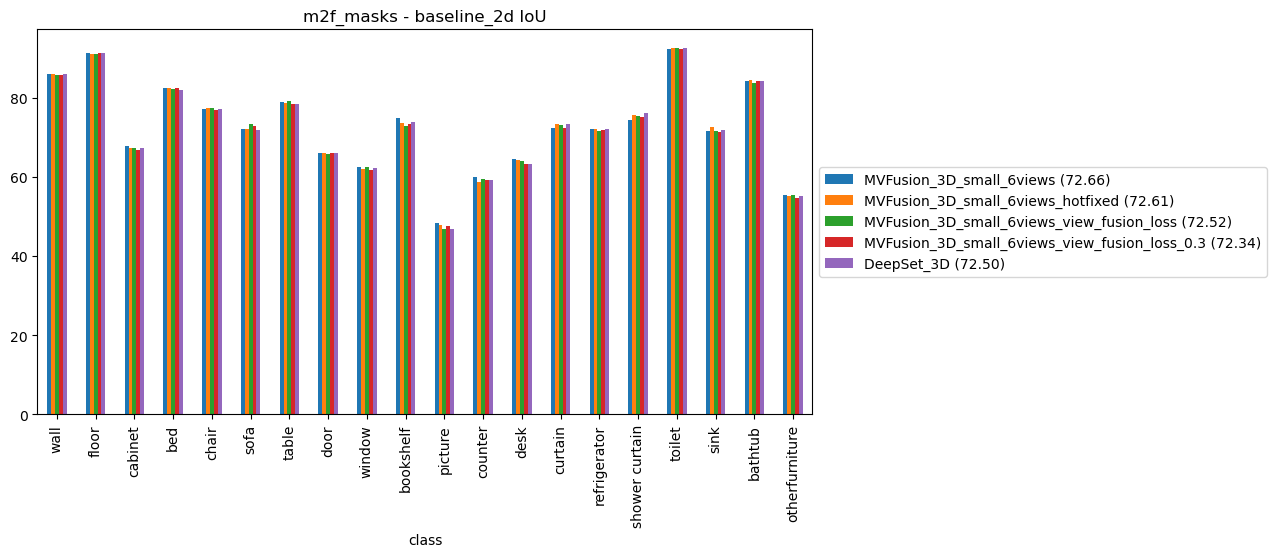

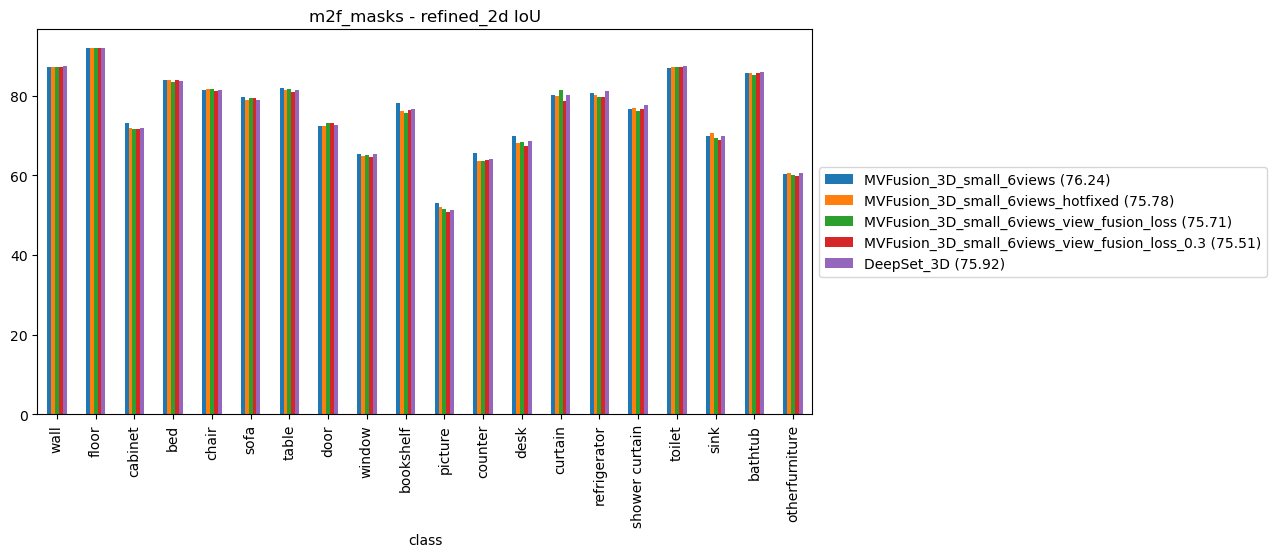

In [52]:
import re
import os
import pandas as pd


def read_class_scores(file, dirp="/home/fsun/DeepViewAgg/job_logs"):
    with open(f'{os.path.join(dirp, file)}') as f:
        lines = f.readlines()

        pattern = 'val_miou_per_class = '
        matching_lines = [line for line in lines if pattern in line]
#         train_scores = [float(m.split()[-1]) / 100 for m in matching_lines]
        
        if len(matching_lines) == 16:
            matching_lines = matching_lines[-4:]
        elif len(matching_lines) == 32 :
            matching_lines = matching_lines[-4:]
        else:
            return None
            
        scores = [re.split("{|}", m)[1] for m in matching_lines]
                    
        res_dict = {}
        metrics = ['baseline_3d', 'baseline_2d', 'refined_3d', 'refined_2d']
        for i in range(4):
            scores_list = []
            for pair in scores[i].split(","):
                k, v = pair.split(": ")
                k, v = int(k), float(v.replace("'", ""))

                scores_list.append(v)
                
            res_dict[metrics[i]] = scores_list
            
        res_dict['model_name'] = file.split(os.sep)[-1][:-4]  # leave out .out
        res_dict['input_mask'] = file.split(os.sep)[-2]
            
        return res_dict


names = [
#     'thesis_results/m2f_masks/MVFusion_small_6views_hotfixed.out', # 0
#     'thesis_results/m2f_masks/MVFusion_small_6views_hotfixed_onecyclelr.out',

    'thesis_results/m2f_masks/MVFusion_3D_small_6views.out',       # 1
    'thesis_results/m2f_masks/MVFusion_3D_small_6views_hotfixed.out', # 2
    'thesis_results/m2f_masks/MVFusion_3D_small_6views_view_fusion_loss.out', # 3
    'thesis_results/m2f_masks/MVFusion_3D_small_6views_view_fusion_loss_0.3.out', # 4
    'thesis_results/m2f_masks/DeepSet_3D.out',

    'thesis_results/ViT_masks/MVFusion_3D_small_6views.out', # 5
    'thesis_results/ViT_masks/MVFusion_3D_small_6views_hotfixed.out', # 6
    
    'thesis_results/ViT_masks/DeepSet_bs6_lr0.06.out'
]

model_results = []
for i in range(len(names)):    
    metrics = read_class_scores(names[i])
    
    if metrics == None:
        print(f"{names[i]} file is incorrectly formatted!")
        continue
        
    model_results.append(metrics)
                
        
        
def plot_barplot(list_of_dics, metric_name='refined_3d', mask_name='ViT_masks'): 
    # Create dataframe
    col_names = ['input_mask', 'model_name'] + list(range(20))
    
    data = {'class': CLASS_NAMES[:-1]}
    
    for d in list_of_dics:
        if d['input_mask'] == mask_name:
            data[d['model_name']] = d[metric_name]
            
    df = pd.DataFrame.from_dict(data)
    
    # Multi barplot
    ax = df.plot(x="class", y=df.columns[1:], kind="bar", rot=90, figsize=(10, 5))
    ax.set_title(f"{mask_name} - {metric_name} IoU")
    legend = ['%s (%.2f)' %(col_name, df[col_name].mean()) 
          for col_name in df.columns[1:]]
    ax.legend(legend, loc='center left', bbox_to_anchor=(1, 0.5))
    
#     return df
        
        
plot_barplot(model_results, metric_name='baseline_2d', mask_name='m2f_masks')
plot_barplot(model_results, metric_name='refined_2d', mask_name='m2f_masks')


# ViT_masks after hotfix show slight improvement in some classes (unsure because of what).



In [51]:
names = [
    'thesis_results/m2f_masks/MVFusion_small_6views_hotfixed.out', # 0
    'thesis_results/m2f_masks/MVFusion_small_6views_hotfixed_onecyclelr.out',

    'thesis_results/m2f_masks/MVFusion_3D_small_6views.out',       # 1
    'thesis_results/m2f_masks/MVFusion_3D_small_6views_hotfixed.out', # 2
    'thesis_results/m2f_masks/MVFusion_3D_small_6views_view_fusion_loss.out', # 3
    'thesis_results/m2f_masks/MVFusion_3D_small_6views_view_fusion_loss_0.3.out', # 4

    'thesis_results/ViT_masks/MVFusion_3D_small_6views.out', # 5
    'thesis_results/ViT_masks/MVFusion_3D_small_6views_hotfixed.out', # 6
]

for i in range(len(names)):
    try:
        data = read_scores(file=names[i])
        if len(data['val_scores']) > len(data['val_losses']):
            data['val_scores'] = data['val_scores'][:-4]
        
        plot_graph(data, log_scale=False, title=names[i])

        # Generalization error
        val_range = range(4, len(data['train_losses']) - len(data['train_losses']) % 5, 5)
        gen_error = np.array(data['val_losses']) - np.array([data['train_losses'][i] for i in val_range])
        # plot_barchart(val_range, gen_error, 'Generalization error')
        plot_barchart(val_range, data['val_scores'], names[i], ylim=[0.7, 0.8])
        print("Max val score: ", max(data['val_scores']))
    except:
        print(len(data['train_scores']))
        print(len(data['train_losses']))
        print(len(data['val_scores']))
        print(len(data['val_losses']))
        print(data['val_scores'])
        print(f"{names[i]} is broken!")
        continue

NameError: name 'data' is not defined